# Regression 2

In [ ]:


import functions

import os
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# for statistical tests
from scipy.stats import ttest_rel, ttest_ind
from statsmodels.stats.multitest import multipletests

# for regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor

In [216]:
import importlib
importlib.reload(functions)

<module 'functions' from '/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py'>

## Loading the data

In [191]:
excel_folder_path = "data/"
FM_folder_path = "data/Raw_MissingDataImputed/"
regression_info, rsfMRI_full_info = functions.load_excel_data(excel_folder_path, FM_folder_path)
folder_path = "FC_matrices_times_wp11/"

rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 12, 54, 56, 78, 96, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]
rois_sub = rois
rois_full = np.arange(0, 379)
selected_rois = [362, 363, 364, 367, 371, 372, 373, 376]
striatum_labels = [
    'Caudate_ipsi', 'Putamen_ipsi', 'Caudate_contra', 'Putamen_contra', 'Pallidum_ipsi', 'Pallidum_contra', 
    'Accumbens_ipsi', 'Accumbens_contra'
]

striatum_labels = [
    'Caudate_ipsi', 'Putamen_ipsi', 'Caudate_contra', 'Putamen_contra', 'Pallidum_ipsi', 'Pallidum_contra', 
    'Accumbens_ipsi', 'Accumbens_contra'
]
all_matrices, all_subjects, yeo_mat_all_rois, roi_mapping_yeo = functions.load_matrices(folder_path, rsfMRI_full_info, rois, request_type='all', plot=False)
t1_t3_t4_matched = all_matrices.copy().dropna(subset=['T1_matrix', 'T3_matrix', 'T4_matrix'])

roi_mapping = functions.load_roi_labels("data/HCP-MMP1_RegionsCorticesList_379.csv")  # adapt path

Trying to load: TiMeS_matrix_mdImputed_allT4.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT4.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT3.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT3.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT2.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT2.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT1.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT1.xlsx


In [199]:
df_aligned = functions.switch_contra_ipsi_df(
    t1_t3_t4_matched, 
    regression_info, 
    tp=1, 
    rois=rois, 
    roi_mapping=roi_mapping
)
df_L, df_R = functions.split_by_lesion_side(t1_t3_t4_matched)
print(f"{len(df_L)} left-lesioned subjects")
print(f"{len(df_R)} right-lesioned subjects")


df_aligned_L = functions.switch_contra_ipsi_df(
    df_L, 
    regression_info, 
    tp=3, 
    rois=rois, 
    roi_mapping=roi_mapping
)

df_aligned_R = functions.switch_contra_ipsi_df(
    df_R, 
    regression_info, 
    tp=3, 
    rois=rois, 
    roi_mapping=roi_mapping
)

8 left-lesioned subjects
17 right-lesioned subjects


In [200]:
print(f"Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side: {len(df_aligned)}")
print("Number of predictors: ", len(rois)-1) # I drop Brainstem, as not defined as L or R

Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side: 25
Number of predictors:  32


In [201]:
t1_t3_t4_matched_sel = df_aligned.copy()

for col in ['T1_matrix', 'T3_matrix', 'T_matrix']:
    if col in df_aligned.columns:
        t1_t3_t4_matched_sel[col] = df_aligned[col].apply(lambda mat: functions.keep_selected_rows(mat, striatum_labels))

selected_col = 'T1_matrix'

### No split, T3

In [202]:
tp = 3

# Step 4: Merge with motor scores
regression_t3 = regression_info[
    (regression_info["TimePoint"] == f"T{tp}") &
    (regression_info["Behavioral_assessment"] == 1) &
    (regression_info["MRI"] == 1)
].copy()

valid_data_t3 = t1_t3_t4_matched_sel.merge(
        regression_t3[["subject_id", "nmf_motor", "Fugl_Meyer_contra", "Fugl_Meyer_ipsi"]],
        on="subject_id"
    )


X_t3 = np.array([fc.values.flatten() for fc in valid_data_t3[selected_col]]) 

# Example matrix from one subject
example_fc = valid_data_t3[selected_col].iloc[0]  # shape (8, 33)

# Extract row and column labels
row_labels = example_fc.index.tolist()
col_labels = example_fc.columns.tolist()

# Create ROIxROI feature names
feature_names = [f"{row}|{col}" for row in row_labels for col in col_labels]

X_df_t3 = pd.DataFrame(X_t3, columns=feature_names)  # No scaling
X_df_clean_t3 = X_df_t3.dropna(axis=1) # Shape: (n_subjects=25, 8×32 - diagonal values that are nan = 248)

param_grid = {
    "rfe__n_features_to_select": [5, 10, 17, 18, 19, 20, 21, 22, 23, 24, 30, 40, 80, 160, X_df_clean_t3.shape[1]]
}

In [203]:
print(f"Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side, and with behav result at T{tp}: {len(valid_data_t3)}")

Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side, and with behav result at T3: 25


NB: As there are 8 diagonal values, 8 columns will be full of empty data

### No split, T4

In [204]:
tp = 4

# Step 4: Merge with motor scores
regression_t4 = regression_info[
    (regression_info["TimePoint"] == f"T{tp}") &
    (regression_info["Behavioral_assessment"] == 1) &
    (regression_info["MRI"] == 1)
].copy()

valid_data_t4 = t1_t3_t4_matched_sel.merge(
        regression_t4[["subject_id", "nmf_motor", "Fugl_Meyer_contra", "Fugl_Meyer_ipsi"]],
        on="subject_id"
    )

X_t4 = np.array([fc.values.flatten() for fc in valid_data_t4[selected_col]]) 

# Example matrix from one subject
example_fc = valid_data_t4[selected_col].iloc[0]  # shape (8, 33)

# Extract row and column labels
row_labels = example_fc.index.tolist()
col_labels = example_fc.columns.tolist()

# Create ROIxROI feature names
feature_names = [f"{row}|{col}" for row in row_labels for col in col_labels]

X_df_t4 = pd.DataFrame(X_t4, columns=feature_names)  # No scaling
X_df_clean_t4 = X_df_t4.dropna(axis=1) # Shape: (n_subjects=25, 8×32 - diagonal values that are nan = 248)

param_grid = {
    "rfe__n_features_to_select": [5, 10, 17, 18, 19, 20, 21, 22, 23, 24, 30, 40, 80, 160, X_df_clean_t4.shape[1]]
}

In [205]:
print(f"Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side, and behav results at T{tp}: {len(valid_data_t4)}")

Number of subjects with T1, T3, and T4 matrices, and without undefined stroke lesion side, and behav results at T4: 23


NB: As there are 8 diagonal values, 8 columns will be full of empty data

### Split, L

In [206]:
t1_t3_t4_matched_sel_L = df_aligned_L.copy()

for col in ['T1_matrix', 'T3_matrix', 'T_matrix']:
    if col in df_aligned_L.columns:
        t1_t3_t4_matched_sel_L[col] = df_aligned_L[col].apply(lambda mat: functions.keep_selected_rows(mat, striatum_labels))

#### T3

In [207]:
valid_data_L_t3 = t1_t3_t4_matched_sel_L.merge(
        regression_t3[["subject_id", "nmf_motor", "Fugl_Meyer_contra", "Fugl_Meyer_ipsi"]],
        on="subject_id"
    )

X_L_t3 = np.array([fc.values.flatten() for fc in valid_data_L_t3[selected_col]]) 

# Example matrix from one subject
example_fc = valid_data_L_t3[selected_col].iloc[0]  # shape (8, 33)

# Extract row and column labels
row_labels = example_fc.index.tolist()
col_labels = example_fc.columns.tolist()

# Create ROIxROI feature names
feature_names = [f"{row}|{col}" for row in row_labels for col in col_labels]

X_df_L_t3 = pd.DataFrame(X_L_t3, columns=feature_names)  # No scaling
X_df_clean_L_t3 = X_df_L_t3.dropna(axis=1) # Shape: (n_subjects=25, 8×32 - diagonal values that are nan = 248)

param_grid = {
    "rfe__n_features_to_select": [5, 10, 17, 18, 19, 20, 21, 22, 23, 24, 30, 40, 80, 160, X_df_clean_L_t3.shape[1]]
}

#### T4

In [208]:
valid_data_L_t4 = t1_t3_t4_matched_sel_L.merge(
        regression_t4[["subject_id", "nmf_motor", "Fugl_Meyer_contra", "Fugl_Meyer_ipsi"]],
        on="subject_id"
    )

X_L_t4 = np.array([fc.values.flatten() for fc in valid_data_L_t4[selected_col]]) 

# Example matrix from one subject
example_fc = valid_data_L_t4[selected_col].iloc[0]  # shape (8, 33)

# Extract row and column labels
row_labels = example_fc.index.tolist()
col_labels = example_fc.columns.tolist()

# Create ROIxROI feature names
feature_names = [f"{row}|{col}" for row in row_labels for col in col_labels]

X_df_L_t4 = pd.DataFrame(X_L_t4, columns=feature_names)  # No scaling
X_df_clean_L_t4 = X_df_L_t4.dropna(axis=1) # Shape: (n_subjects=25, 8×32 - diagonal values that are nan = 248)

param_grid = {
    "rfe__n_features_to_select": [5, 10, 17, 18, 19, 20, 21, 22, 23, 24, 30, 40, 80, 160, X_df_clean_L_t4.shape[1]]
}

### Split, R

In [209]:
t1_t3_t4_matched_sel_R = df_aligned_R.copy()

for col in ['T1_matrix', 'T3_matrix', 'T_matrix']:
    if col in df_aligned_R.columns:
        t1_t3_t4_matched_sel_R[col] = df_aligned_R[col].apply(lambda mat: functions.keep_selected_rows(mat, striatum_labels))

selected_col = 'T1_matrix'

#### T3

In [210]:
valid_data_R_t3 = t1_t3_t4_matched_sel_R.merge(
        regression_t3[["subject_id", "nmf_motor", "Fugl_Meyer_contra", "Fugl_Meyer_ipsi"]],
        on="subject_id"
    )

X_R_t3 = np.array([fc.values.flatten() for fc in valid_data_R_t3[selected_col]]) 

# Example matrix from one subject
example_fc = valid_data_R_t3[selected_col].iloc[0]  # shape (8, 33)

# Extract row and column labels
row_labels = example_fc.index.tolist()
col_labels = example_fc.columns.tolist()

# Create ROIxROI feature names
feature_names = [f"{row}|{col}" for row in row_labels for col in col_labels]

X_df_R_t3 = pd.DataFrame(X_R_t3, columns=feature_names)  # No scaling
X_df_clean_R_t3 = X_df_R_t3.dropna(axis=1) # Shape: (n_subjects=25, 8×32 - diagonal values that are nan = 248)

param_grid = {
    "rfe__n_features_to_select": [5, 10, 17, 18, 19, 20, 21, 22, 23, 24, 30, 40, 80, 160, X_df_clean_R_t3.shape[1]]
}

#### T4

In [211]:
valid_data_R_t4 = t1_t3_t4_matched_sel_R.merge(
        regression_t4[["subject_id", "nmf_motor", "Fugl_Meyer_contra", "Fugl_Meyer_ipsi"]],
        on="subject_id"
    )

X_R_t4 = np.array([fc.values.flatten() for fc in valid_data_R_t4[selected_col]]) 

# Example matrix from one subject
example_fc = valid_data_R_t4[selected_col].iloc[0]  # shape (8, 33)

# Extract row and column labels
row_labels = example_fc.index.tolist()
col_labels = example_fc.columns.tolist()

# Create ROIxROI feature names
feature_names = [f"{row}|{col}" for row in row_labels for col in col_labels]

X_df_R_t4 = pd.DataFrame(X_R_t4, columns=feature_names)  # No scaling
X_df_clean_R_t4 = X_df_R_t4.dropna(axis=1) # Shape: (n_subjects=25, 8×32 - diagonal values that are nan = 248)

param_grid = {
    "rfe__n_features_to_select": [5, 10, 17, 18, 19, 20, 21, 22, 23, 24, 30, 40, 80, 160, X_df_clean_R_t4.shape[1]]
}

## Random Forest Regression

In [221]:
# Fugl-Meyer ipsi
X_df_clean_t3, y_FMI_t3, param_grid = functions.preprocess_data_for_regression(df_aligned, regression_info, tp=3, motor_score="Fugl_Meyer_ipsi", striatum_labels=striatum_labels)
X_df_clean_t4, y_FMI_t4,param_grid = functions.preprocess_data_for_regression(df_aligned, regression_info, tp=4, motor_score="Fugl_Meyer_ipsi", striatum_labels=striatum_labels)
X_df_clean_L_t3, y_FMI_L_t3, param_grid = functions.preprocess_data_for_regression(df_aligned_L, regression_info, tp=3, motor_score="Fugl_Meyer_ipsi", striatum_labels=striatum_labels)
X_df_clean_L_t4, y_FMI_L_t4, param_grid = functions.preprocess_data_for_regression(df_aligned_L, regression_info, tp=4, motor_score="Fugl_Meyer_ipsi", striatum_labels=striatum_labels)
X_df_clean_R_t3, y_FMI_R_t3, param_grid = functions.preprocess_data_for_regression(df_aligned_R, regression_info, tp=3, motor_score="Fugl_Meyer_ipsi", striatum_labels=striatum_labels)
X_df_clean_R_t4, y_FMI_R_t4, param_grid = functions.preprocess_data_for_regression(df_aligned_R, regression_info, tp=4, motor_score="Fugl_Meyer_ipsi", striatum_labels=striatum_labels)

# Fugl-Meyer contra
X_df_clean_t3, y_FMC_t3, param_grid = functions.preprocess_data_for_regression(df_aligned, regression_info, tp=3, motor_score="Fugl_Meyer_contra", striatum_labels=striatum_labels)
X_df_clean_t4, y_FMC_t4, param_grid = functions.preprocess_data_for_regression(df_aligned, regression_info, tp=4, motor_score="Fugl_Meyer_contra", striatum_labels=striatum_labels)
X_df_clean_L_t3, y_FMC_L_t3, param_grid = functions.preprocess_data_for_regression(df_aligned_L, regression_info, tp=3, motor_score="Fugl_Meyer_contra", striatum_labels=striatum_labels)
X_df_clean_L_t4, y_FMC_L_t4, param_grid = functions.preprocess_data_for_regression(df_aligned_L, regression_info, tp=4, motor_score="Fugl_Meyer_contra", striatum_labels=striatum_labels)
X_df_clean_R_t3, y_FMC_R_t3, param_grid = functions.preprocess_data_for_regression(df_aligned_R, regression_info, tp=3, motor_score="Fugl_Meyer_contra", striatum_labels=striatum_labels)
X_df_clean_R_t4, y_FMC_R_t4, param_grid = functions.preprocess_data_for_regression(df_aligned_R, regression_info, tp=4, motor_score="Fugl_Meyer_contra", striatum_labels=striatum_labels)

# NMF motor
X_df_clean_t3, y_nmf_t3, param_grid = functions.preprocess_data_for_regression(df_aligned, regression_info, tp=3, motor_score="nmf_motor", striatum_labels=striatum_labels)
X_df_clean_t4, y_nmf_t4, param_grid = functions.preprocess_data_for_regression(df_aligned, regression_info, tp=4, motor_score="nmf_motor", striatum_labels=striatum_labels)
X_df_clean_L_t3, y_nmf_L_t3, param_grid = functions.preprocess_data_for_regression(df_aligned_L, regression_info, tp=3, motor_score="nmf_motor", striatum_labels=striatum_labels)
X_df_clean_L_t4, y_nmf_L_t4, param_grid = functions.preprocess_data_for_regression(df_aligned_L, regression_info, tp=4, motor_score="nmf_motor", striatum_labels=striatum_labels)
X_df_clean_R_t3, y_nmf_R_t3, param_grid = functions.preprocess_data_for_regression(df_aligned_R, regression_info, tp=3, motor_score="nmf_motor", striatum_labels=striatum_labels)
X_df_clean_R_t4, y_nmf_R_t4, param_grid = functions.preprocess_data_for_regression(df_aligned_R, regression_info, tp=4, motor_score="nmf_motor", striatum_labels=striatum_labels)

### Whole Group

#### T3

##### Fuegl-Meyer Ipsi

In [220]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_t3, y_FMI_t3, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -0.7927294318732868


##### Fuegl-Meyer Contra

In [222]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_t3, y_FMC_t3, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -31.250885311186938


##### nmf motor

In [223]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_t3, y_nmf_t3, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -25.180530689655953


#### T4

##### Fuegl-Meyer Ipsi

In [224]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_t4, y_FMI_t4, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -0.40553654371499576


##### Fuegl-Meyer Contra

In [225]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_t4, y_FMC_t4, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -60.7304565828737


##### nmf motor

In [226]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_t4, y_nmf_t4, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -28.93118992949173


### Split L/R

#### L, T3

##### Fuegl-Meyer Ipsi

In [227]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_L_t3, y_FMI_L_t3, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


##### Fuegl-Meyer Contra

In [228]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_L_t3, y_FMC_L_t3, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


##### nmf motor

In [229]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_L_t3, y_nmf_L_t3, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


#### L, T4

##### Fuegl-Meyer Ipsi

In [230]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_L_t4, y_FMI_L_t4, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


##### Fuegl-Meyer Contra

In [231]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_L_t4, y_FMC_L_t4, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


##### nmf motor

In [232]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_L_t4, y_nmf_L_t4, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


#### R, T3

##### Fuegl-Meyer Ipsi

In [233]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_R_t3, y_FMI_R_t3, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -0.9086396979472146


##### Fuegl-Meyer Contra

In [234]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_R_t3, y_FMC_R_t3, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -28.25466531486206


##### nmf motor

In [235]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_R_t3, y_nmf_R_t3, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -77.94506033042407


#### R, T4

##### Fuegl-Meyer Ipsi

In [236]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_R_t4, y_FMI_R_t4, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -0.23844974175137193


##### Fuegl-Meyer Contra

In [237]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_R_t4, y_FMC_R_t4, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -0.4528985151515152


##### nmf motor

In [238]:
# Pipeline: standardize, then fit Random Forest
pipe = Pipeline([
    ("scaler", StandardScaler()),  # optional, not always needed for RF
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(pipe, X_df_clean_R_t4, y_nmf_R_t4, cv=cv, scoring='r2')
print("Random Forest R² (CV):", scores.mean())


Random Forest R² (CV): -4.374603529275107


# Ridge Regression rois

#### Modeling Rationale: RFE, Ridge Regression, and R² Scoring

To predict motor behavior from functional connectivity (FC) features, we used a modeling pipeline combining **Recursive Feature Elimination (RFE)**, **Ridge Regression**, and **R² scoring**, selected based on the nature of our data and the goals of the analysis.

##### Why RFE?
**Recursive Feature Elimination (RFE)** is a wrapper-based feature selection method that iteratively removes the least informative features based on model performance. This is particularly important in neuroimaging datasets, where:

- The number of features (e.g., FC links) often exceeds the number of subjects.
- Many features are noisy or redundant.
- We seek interpretability: RFE helps identify a **compact, informative subset** of brain connections most predictive of motor outcomes.

##### Why Ridge Regression?
We used **Ridge regression** (ℓ2-regularized linear regression) because:

- It handles **high-dimensional data** well, where standard linear regression would overfit.
- It is robust to **multicollinearity**, which is common in brain connectivity data (many FC features are correlated).
- It regularizes coefficient estimates, improving model generalization without forcing sparsity (unlike Lasso).

##### Why R² Scoring?
We evaluated model performance using **R² (coefficient of determination)** because:

- It quantifies how much variance in the motor outcome is explained by the model.
- It is scale-invariant and interpretable: e.g., an R² of 0.6 means 60% of the variance is explained.
- It is standard in regression analysis and particularly useful for comparing predictive performance across models and feature sets.

---

Together, this pipeline provides a statistically sound, interpretable, and generalizable approach for linking FC features to behavioral outcomes.


## Whole-group

### T3

#### FMI

Running Ridge regression with RFE for Fugl_Meyer_ipsi at time point T 3
Best number of features: 80
Best cross-validated R² score: -0.8967596395630199
Top predictive features:
                                  Feature    Weight
11             Caudate_ipsi|Area_2_contra  0.125379
17          Caudate_contra|Cerebellu_ipsi -0.117179
29    Putamen_contra|Area_6_anterior_ipsi -0.101334
23           Caudate_contra|Area_1_contra  0.101215
24           Caudate_contra|Area_2_contra  0.099969
27      Putamen_contra|Dorsal_area_6_ipsi -0.099923
14             Putamen_ipsi|Thalamus_ipsi  0.093715
22  Caudate_contra|Area_6_anterior_contra  0.090456
10             Caudate_ipsi|Area_1_contra  0.088217
58           Pallidum_contra|Area_3a_ipsi -0.084413
R² on full data: 1.000
Mean Squared Error: 0.000
Mean Absolute Error: 0.009
Plotting data distribution and predictions for Fugl_Meyer_ipsi at time point T 3


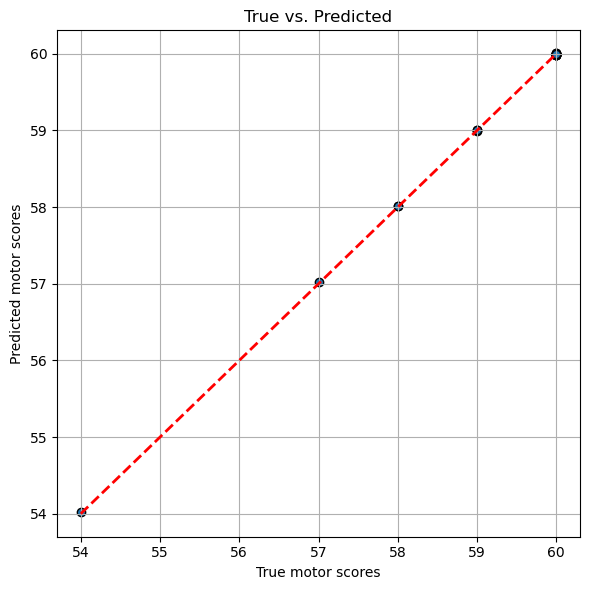

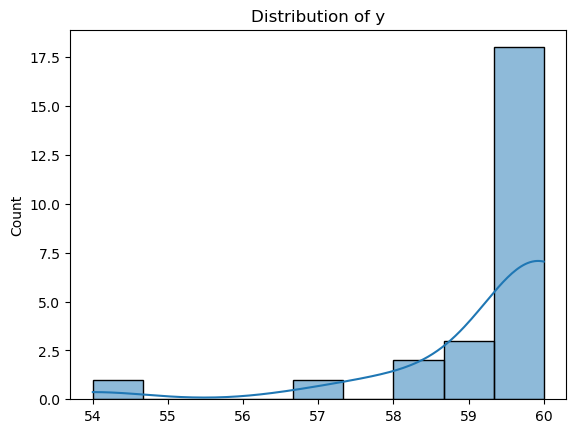

Plotting CDF for Fugl_Meyer_ipsi at time point T 3 , min/max: 54.0 60.0


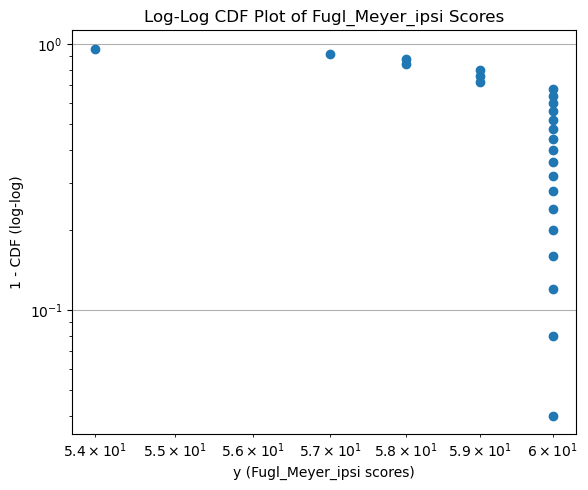

Plotting histogram with log-scaled y-axis for Fugl_Meyer_ipsi at time point T 3 to check for right-skewed distribution


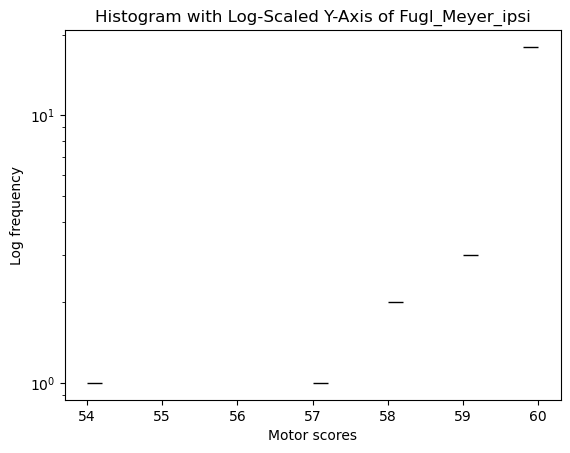

Plotting histogram of log1p(max - y) for Fugl_Meyer_ipsi at time point T 3 to check for left-skewed distribution


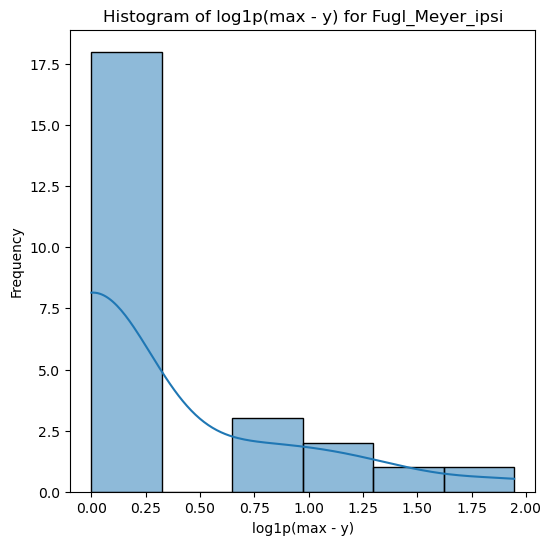

Running Ridge regression with RFE on reflected log-transformed y for Fugl_Meyer_ipsi at time point T 3
Best number of features: 80
Best cross-validated R² score: -0.39648542577077384
Top predictive features:
                                  Feature    Weight
29    Putamen_contra|Area_6_anterior_ipsi  0.050586
11             Caudate_ipsi|Area_2_contra -0.047518
17          Caudate_contra|Cerebellu_ipsi  0.045441
44          Pallidum_ipsi|Thalamus_contra  0.044920
27      Putamen_contra|Dorsal_area_6_ipsi  0.042586
12             Putamen_ipsi|Thalamus_ipsi -0.041279
19      Caudate_contra|Dorsal_area_6_ipsi  0.037605
58           Pallidum_contra|Area_3a_ipsi  0.035898
24           Caudate_contra|Area_1_contra -0.035667
23  Caudate_contra|Area_6_anterior_contra -0.034590
Running Ridge regression with RFE on log-transformed y for Fugl_Meyer_ipsi at time point T 3
Best number of features: 80
Best cross-validated R² score: -0.9696702260901313
Top predictive features:
                       

In [195]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned, regression_info, tp=3, motor_score='Fugl_Meyer_ipsi', striatum_labels=striatum_labels)

#### FMC

Running Ridge regression with RFE for Fugl_Meyer_contra at time point T 3
Best number of features: 160
Best cross-validated R² score: -60.43669728668206
Top predictive features:
                                        Feature    Weight
71                  Putamen_contra|Area_3a_ipsi  1.096937
154            Accumbens_contra|Area_55b_contra -0.967840
9                  Caudate_ipsi|Area_55b_contra -0.958311
35   Putamen_ipsi|Primary_Sensory_Cortex_contra -0.909875
113        Pallidum_contra|Dorsal_area_6_contra  0.908356
131                 Accumbens_ipsi|Area_3a_ipsi -0.897579
18                   Putamen_ipsi|Area_55b_ipsi  0.891003
102          Pallidum_contra|Dorsal_area_6_ipsi -0.871487
112             Pallidum_contra|Area_55b_contra  0.870656
37                  Putamen_ipsi|Area_3a_contra -0.839621
R² on full data: 1.000
Mean Squared Error: 0.015
Mean Absolute Error: 0.075
Plotting data distribution and predictions for Fugl_Meyer_contra at time point T 3


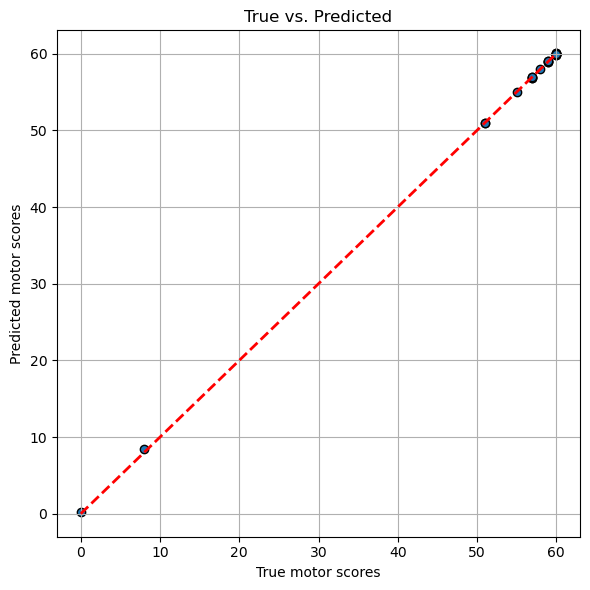

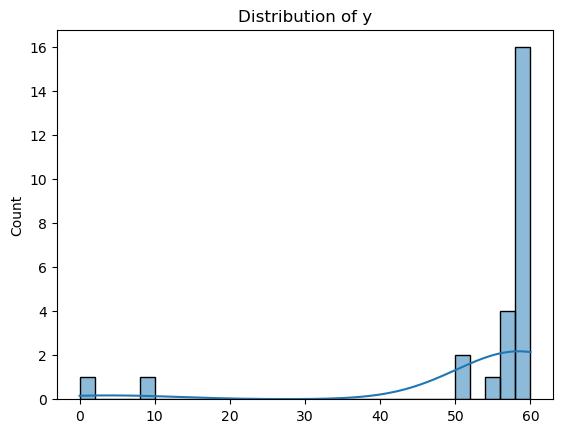

Plotting CDF for Fugl_Meyer_contra at time point T 3 , min/max: 0.0 60.0


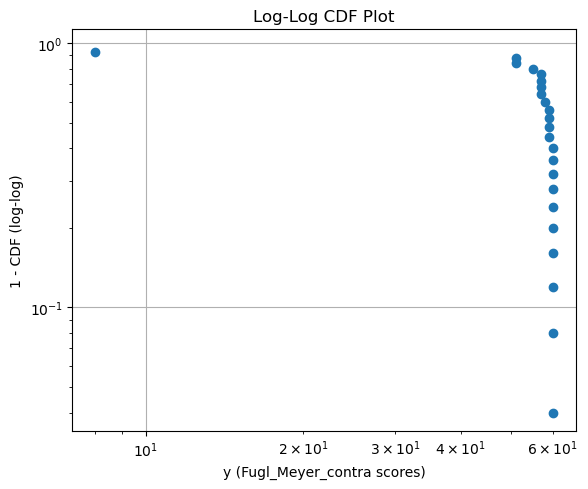

Plotting histogram with log-scaled y-axis for Fugl_Meyer_contra at time point T 3 to check for right-skewed distribution


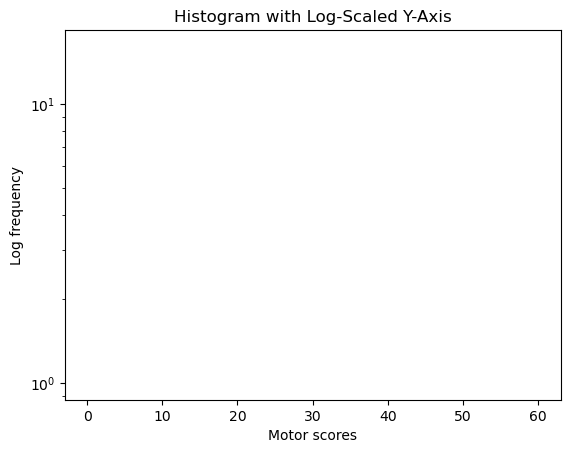

Plotting histogram of log1p(max - y) for Fugl_Meyer_contra at time point T 3 to check for left-skewed distribution


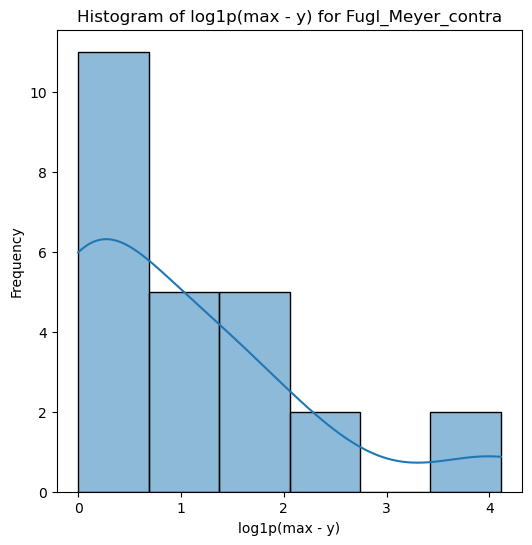

Running Ridge regression with RFE on reflected log-transformed y for Fugl_Meyer_contra at time point T 3
Best number of features: 248
Best cross-validated R² score: -1.4680233170787196
Top predictive features:
                                      Feature    Weight
36                 Putamen_ipsi|Area_55b_ipsi -0.081212
108               Putamen_contra|Area_3a_ipsi -0.079745
162        Pallidum_contra|Dorsal_area_6_ipsi  0.079263
176           Pallidum_contra|Area_55b_contra -0.065113
194        Accumbens_ipsi|Rostral_Area_6_ipsi -0.063269
118     Putamen_contra|Area_6_anterior_contra  0.060902
61                Putamen_ipsi|Area_3a_contra  0.057994
57   Putamen_ipsi|Primary_Motor_Cortex_contra  0.057881
104  Putamen_contra|Primary_Motor_Cortex_ipsi -0.055996
113            Putamen_contra|Thalamus_contra  0.055912
Running Ridge regression with RFE on log-transformed y for Fugl_Meyer_contra at time point T 3
Best number of features: 248
Best cross-validated R² score: -454.86986930637534

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned, regression_info, tp=3, motor_score='Fugl_Meyer_contra', striatum_labels=striatum_labels)

#### nmf

Running Ridge regression with RFE for nmf_motor at time point T 3


Best number of features: 248
Best cross-validated R² score: -34.27761585296581
Top predictive features:
                                        Feature    Weight
21                 Caudate_ipsi|Area_55b_contra  0.013481
108                 Putamen_contra|Area_3a_ipsi -0.013202
238            Accumbens_contra|Area_55b_contra  0.012919
200                 Accumbens_ipsi|Area_3a_ipsi  0.012571
212  Accumbens_ipsi|Primary_Motor_Cortex_contra  0.011244
58   Putamen_ipsi|Primary_Sensory_Cortex_contra  0.011093
61                  Putamen_ipsi|Area_3a_contra  0.010952
72          Caudate_contra|Area_6_anterior_ipsi -0.010459
177        Pallidum_contra|Dorsal_area_6_contra -0.010230
69            Caudate_contra|Dorsal_area_6_ipsi -0.009869
R² on full data: 1.000
Mean Squared Error: 0.000
Mean Absolute Error: 0.001
Plotting data distribution and predictions for nmf_motor at time point T 3


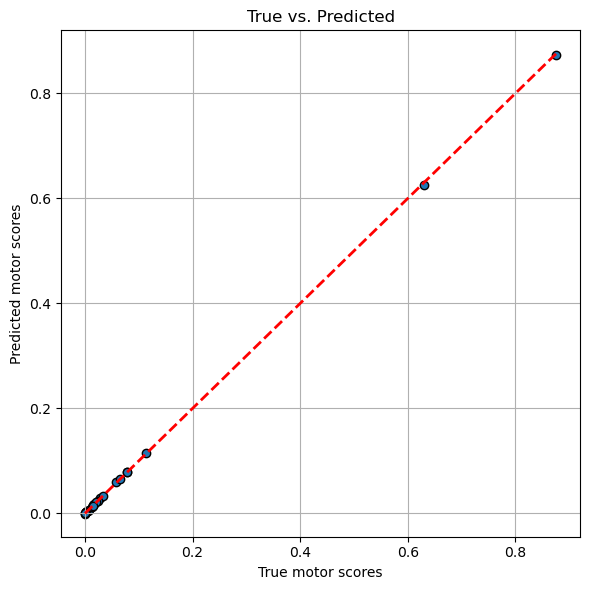

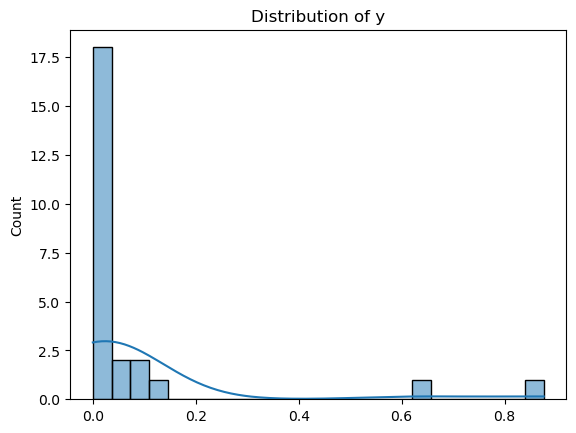

Plotting CDF for nmf_motor at time point T 3 , min/max: 0.0 0.8760608046891752


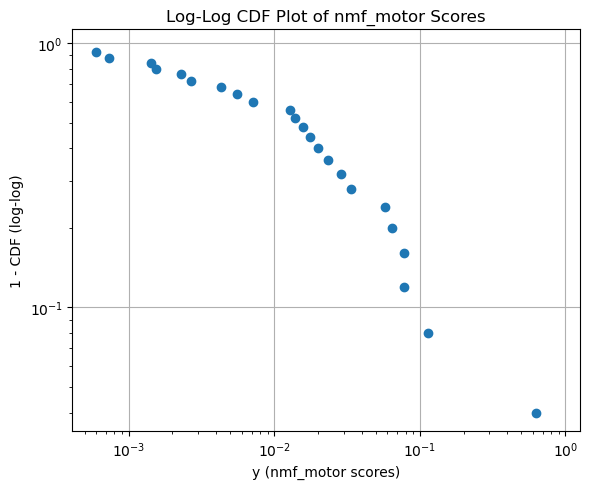

Plotting histogram with log-scaled y-axis for nmf_motor at time point T 3 to check for right-skewed distribution


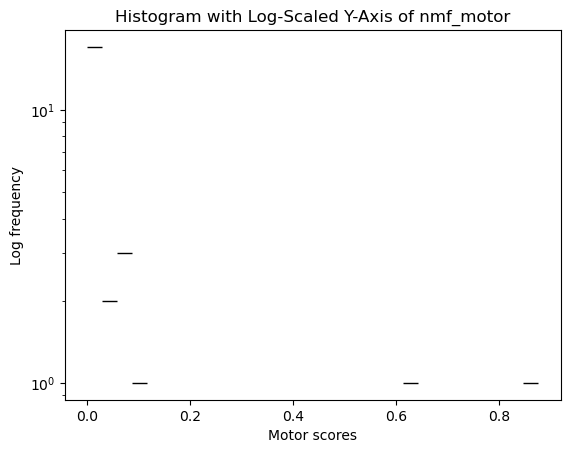

Plotting histogram of log1p(max - y) for nmf_motor at time point T 3 to check for left-skewed distribution


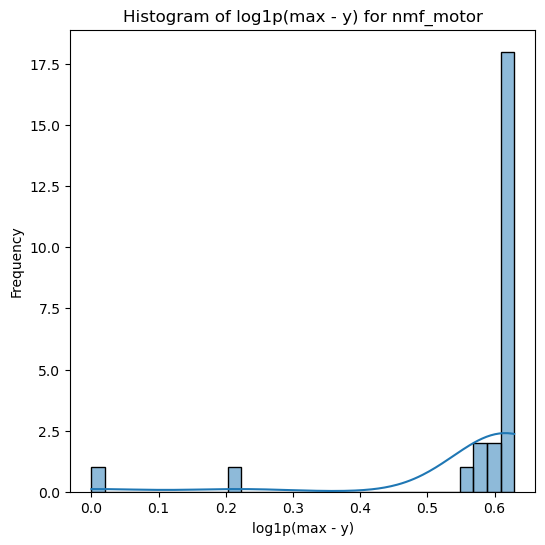

Running Ridge regression with RFE on reflected log-transformed y for nmf_motor at time point T 3
Best number of features: 248
Best cross-validated R² score: -55.84145051099426
Top predictive features:
                                        Feature    Weight
21                 Caudate_ipsi|Area_55b_contra -0.009154
200                 Accumbens_ipsi|Area_3a_ipsi -0.009058
108                 Putamen_contra|Area_3a_ipsi  0.009047
238            Accumbens_contra|Area_55b_contra -0.008667
58   Putamen_ipsi|Primary_Sensory_Cortex_contra -0.008053
212  Accumbens_ipsi|Primary_Motor_Cortex_contra -0.007858
61                  Putamen_ipsi|Area_3a_contra -0.007650
72          Caudate_contra|Area_6_anterior_ipsi  0.007428
69            Caudate_contra|Dorsal_area_6_ipsi  0.007032
177        Pallidum_contra|Dorsal_area_6_contra  0.006960
Running Ridge regression with RFE on log-transformed y for nmf_motor at time point T 3
Best number of features: 248
Best cross-validated R² score: -19.0852196803

In [196]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned, regression_info, tp=3, motor_score='nmf_motor', striatum_labels=striatum_labels)

### T4

#### FMI

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned, regression_info, tp=4, motor_score='Fugl_Meyer_ipsi', striatum_labels=striatum_labels)

#### FMC

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned, regression_info, tp=4, motor_score='Fugl_Meyer_contra', striatum_labels=striatum_labels)

#### nmf

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned, regression_info, tp=4, motor_score='nmf_motor', striatum_labels=striatum_labels)

## L split, T3

### FMI

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_L, regression_info, tp=3, motor_score='Fugl_Meyer_ipsi', striatum_labels=striatum_labels)

AttributeError: module 'functions' has no attribute 'run_whole_pipeline'

### FMC

Running Ridge regression with RFE for Fugl_Meyer_contra at time point T 3


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                              Feature    Weight
1  Caudate_contra|Rostral_Area_6_ipsi  5.571654
2   Pallidum_ipsi|Rostral_Area_6_ipsi  4.950868
3       Pallidum_ipsi|Pallidum_contra  4.361019
0     Putamen_ipsi|Dorsal_area_6_ipsi  3.679055
4    Pallidum_contra|Accumbens_contra  3.595005
R² on full data: 0.976
Mean Squared Error: 6.702
Mean Absolute Error: 2.072
Plotting data distribution and predictions for Fugl_Meyer_contra at time point T 3


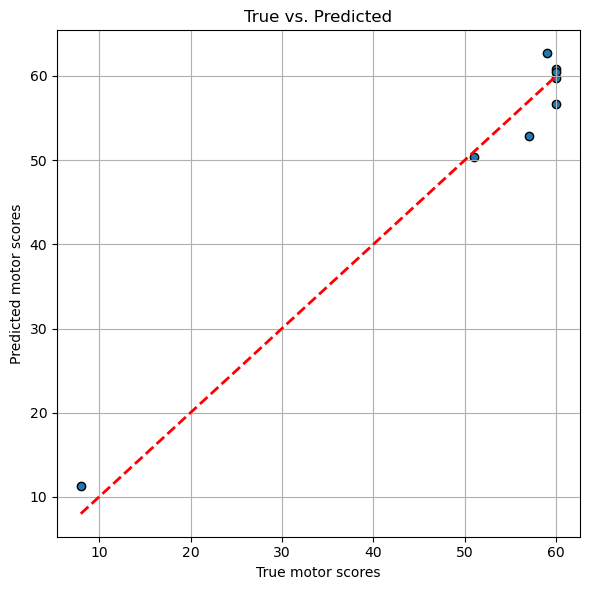

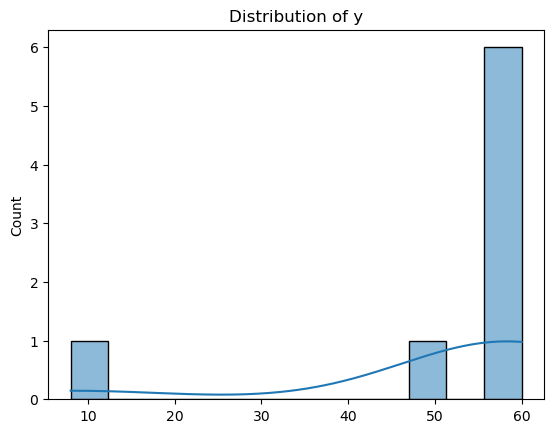

Plotting CDF for Fugl_Meyer_contra at time point T 3 , min/max: 8.0 60.0


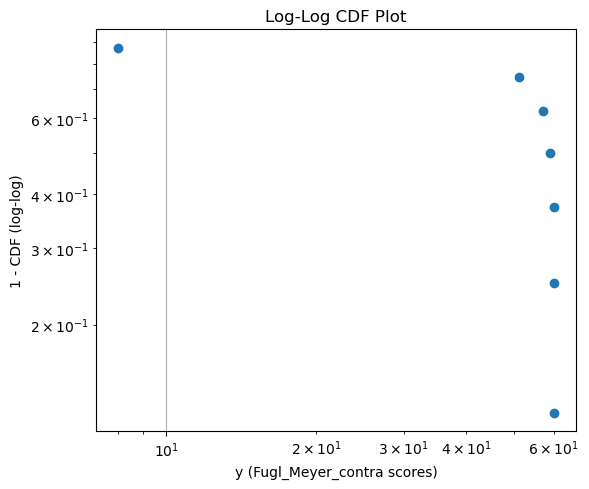

Plotting histogram with log-scaled y-axis for Fugl_Meyer_contra at time point T 3 to check for right-skewed distribution


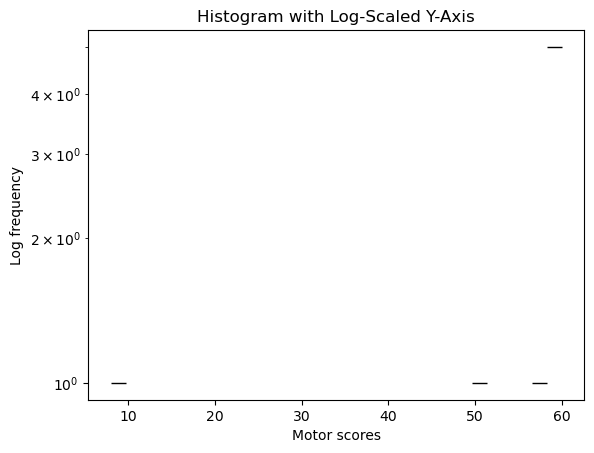

Plotting histogram of log1p(max - y) for Fugl_Meyer_contra at time point T 3 to check for left-skewed distribution


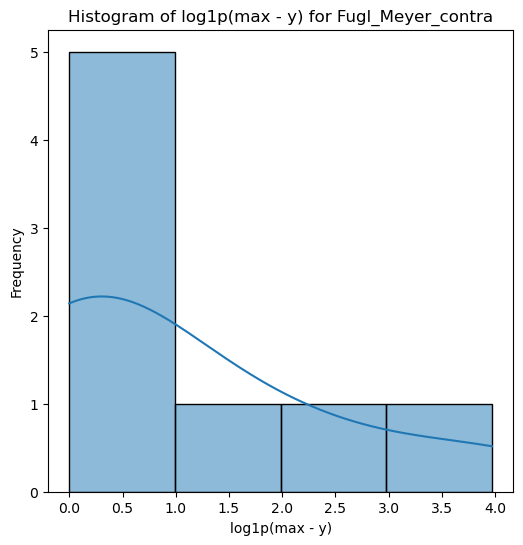

Running Ridge regression with RFE on reflected log-transformed y for Fugl_Meyer_contra at time point T 3


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                                   Feature    Weight
2               Pallidum_ipsi|Area_3a_ipsi -0.467357
0               Putamen_ipsi|Area_55b_ipsi -0.382474
3         Pallidum_contra|Accumbens_contra -0.336656
4       Accumbens_ipsi|Rostral_Area_6_ipsi -0.302611
1  Pallidum_ipsi|Primary_Motor_Cortex_ipsi -0.296779
Running Ridge regression with RFE on log-transformed y for Fugl_Meyer_contra at time point T 3


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                              Feature    Weight
4  Accumbens_ipsi|Rostral_Area_6_ipsi  0.263437
0   Putamen_ipsi|Dorsal_area_6_contra -0.195992
1  Putamen_ipsi|Rostral_Area_6_contra -0.137947
3       Pallidum_contra|Pallidum_ipsi  0.121138
2       Pallidum_ipsi|Pallidum_contra  0.121138
Running Random Forest regression with cross-validation for Fugl_Meyer_contra at time point T 3


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_L, regression_info, tp=3, motor_score='Fugl_Meyer_contra', striatum_labels=striatum_labels)

### nmf

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_L, regression_info, tp=3, motor_score='nmf_motor', striatum_labels=striatum_labels)

## R split, T3

### FMI

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_R, regression_info, tp=3, motor_score='Fugl_Meyer_ipsi', striatum_labels=striatum_labels)

AttributeError: module 'functions' has no attribute 'run_whole_pipeline'

### FMC

Running Ridge regression with RFE for Fugl_Meyer_contra at time point T 3


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                              Feature    Weight
1  Caudate_contra|Rostral_Area_6_ipsi  5.571654
2   Pallidum_ipsi|Rostral_Area_6_ipsi  4.950868
3       Pallidum_ipsi|Pallidum_contra  4.361019
0     Putamen_ipsi|Dorsal_area_6_ipsi  3.679055
4    Pallidum_contra|Accumbens_contra  3.595005
R² on full data: 0.976
Mean Squared Error: 6.702
Mean Absolute Error: 2.072
Plotting data distribution and predictions for Fugl_Meyer_contra at time point T 3


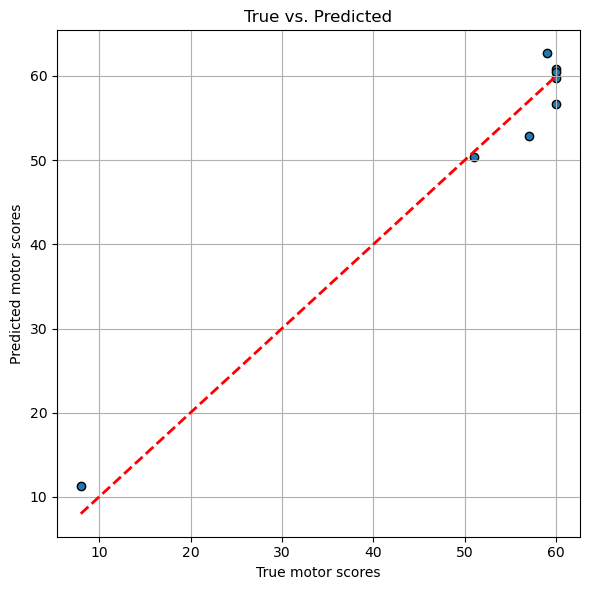

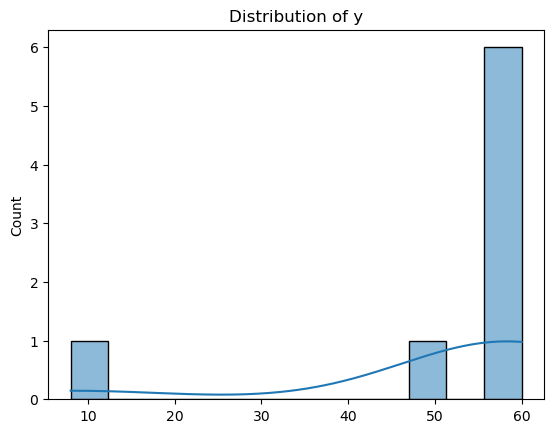

Plotting CDF for Fugl_Meyer_contra at time point T 3 , min/max: 8.0 60.0


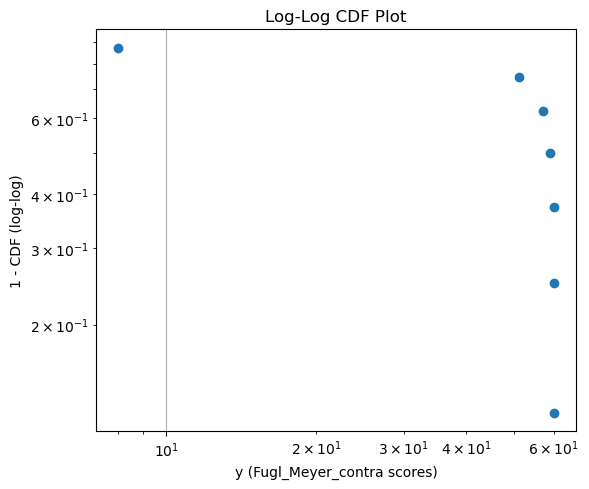

Plotting histogram with log-scaled y-axis for Fugl_Meyer_contra at time point T 3 to check for right-skewed distribution


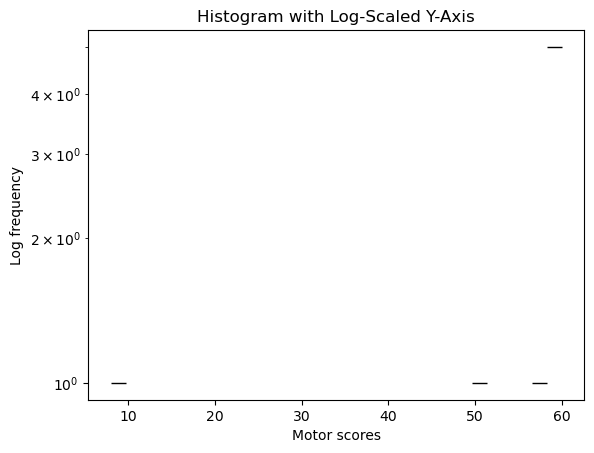

Plotting histogram of log1p(max - y) for Fugl_Meyer_contra at time point T 3 to check for left-skewed distribution


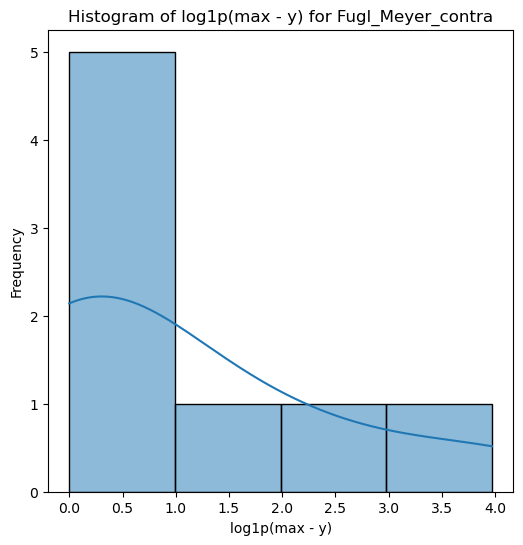

Running Ridge regression with RFE on reflected log-transformed y for Fugl_Meyer_contra at time point T 3


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                                   Feature    Weight
2               Pallidum_ipsi|Area_3a_ipsi -0.467357
0               Putamen_ipsi|Area_55b_ipsi -0.382474
3         Pallidum_contra|Accumbens_contra -0.336656
4       Accumbens_ipsi|Rostral_Area_6_ipsi -0.302611
1  Pallidum_ipsi|Primary_Motor_Cortex_ipsi -0.296779
Running Ridge regression with RFE on log-transformed y for Fugl_Meyer_contra at time point T 3


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                              Feature    Weight
4  Accumbens_ipsi|Rostral_Area_6_ipsi  0.263437
0   Putamen_ipsi|Dorsal_area_6_contra -0.195992
1  Putamen_ipsi|Rostral_Area_6_contra -0.137947
3       Pallidum_contra|Pallidum_ipsi  0.121138
2       Pallidum_ipsi|Pallidum_contra  0.121138
Running Random Forest regression with cross-validation for Fugl_Meyer_contra at time point T 3


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_R, regression_info, tp=3, motor_score='Fugl_Meyer_contra', striatum_labels=striatum_labels)

### nmf

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_R, regression_info, tp=3, motor_score='nmf_motor', striatum_labels=striatum_labels)

## L Split, T4

### Fuegl-Meyer Ipsi

Running Ridge regression with RFE for Fugl_Meyer_ipsi at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                                  Feature    Weight
3  Pallidum_contra|Area_6_anterior_contra -0.334144
2    Pallidum_ipsi|Area_6_anterior_contra -0.293325
0             Caudate_ipsi|Accumbens_ipsi  0.218555
4             Accumbens_ipsi|Caudate_ipsi  0.218555
1               Caudate_ipsi|Area_3a_ipsi -0.160749
R² on full data: 0.991
Mean Squared Error: 0.010
Mean Absolute Error: 0.086
Plotting data distribution and predictions for Fugl_Meyer_ipsi at time point T 4


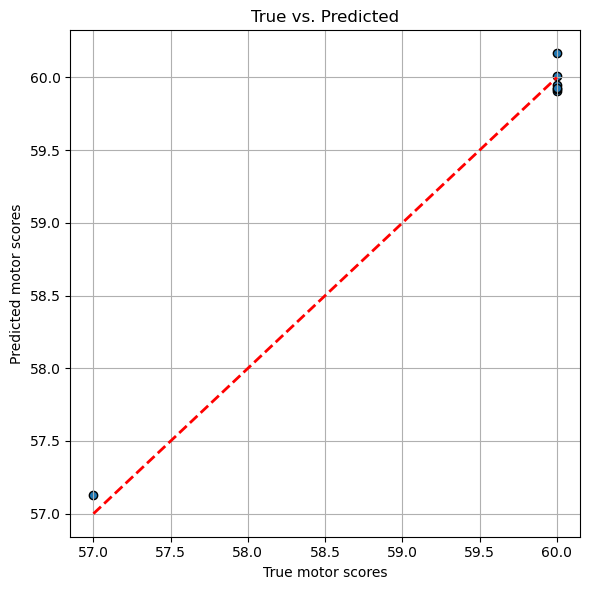

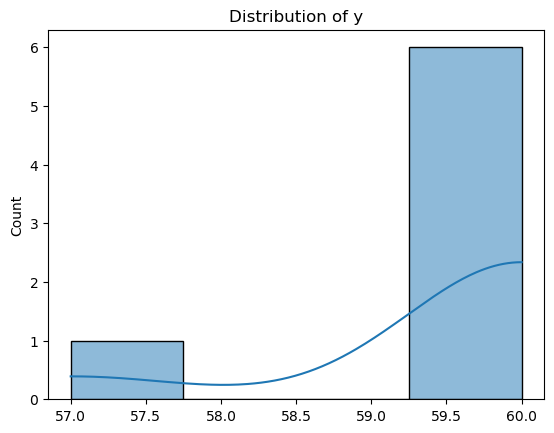

Plotting CDF for Fugl_Meyer_ipsi at time point T 4 , min/max: 57.0 60.0


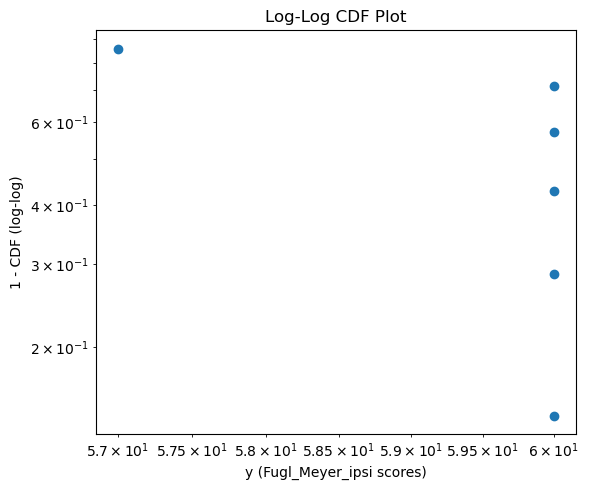

Plotting histogram with log-scaled y-axis for Fugl_Meyer_ipsi at time point T 4 to check for right-skewed distribution


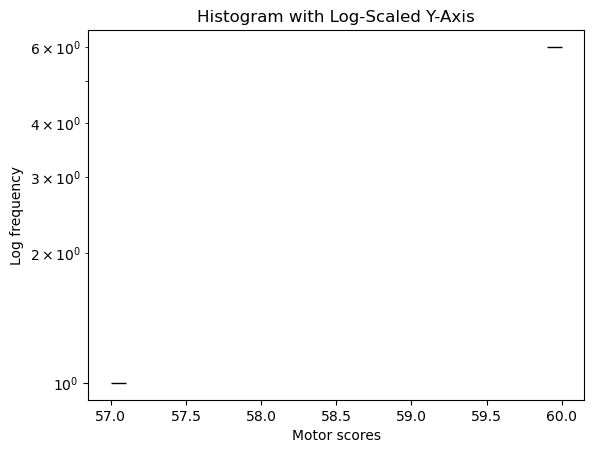

Plotting histogram of log1p(max - y) for Fugl_Meyer_ipsi at time point T 4 to check for left-skewed distribution


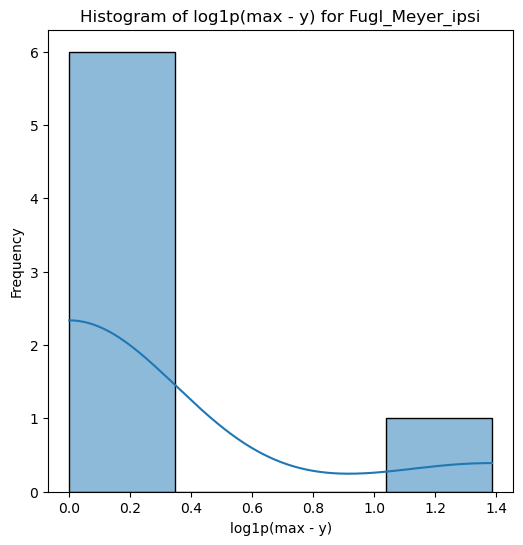

Running Ridge regression with RFE on reflected log-transformed y for Fugl_Meyer_ipsi at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                                  Feature    Weight
3  Pallidum_contra|Area_6_anterior_contra  0.154407
2    Pallidum_ipsi|Area_6_anterior_contra  0.135545
4             Accumbens_ipsi|Caudate_ipsi -0.100994
0             Caudate_ipsi|Accumbens_ipsi -0.100994
1               Caudate_ipsi|Area_3a_ipsi  0.074282
Running Ridge regression with RFE on log-transformed y for Fugl_Meyer_ipsi at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                                  Feature    Weight
3  Pallidum_contra|Area_6_anterior_contra -0.005617
2    Pallidum_ipsi|Area_6_anterior_contra -0.004931
0             Caudate_ipsi|Accumbens_ipsi  0.003674
4             Accumbens_ipsi|Caudate_ipsi  0.003674
1               Caudate_ipsi|Area_3a_ipsi -0.002702
Running Random Forest regression with cross-validation for Fugl_Meyer_ipsi at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_L, regression_info, tp=4, motor_score='Fugl_Meyer_ipsi', striatum_labels=striatum_labels)

### Fuegl-Meyer Contra

Running Ridge regression with RFE for Fugl_Meyer_contra at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                               Feature    Weight
2        Pallidum_contra|Pallidum_ipsi  4.159195
1        Pallidum_ipsi|Pallidum_contra  4.159195
4     Accumbens_contra|Pallidum_contra  3.917064
3     Pallidum_contra|Accumbens_contra  3.917064
0  Caudate_contra|Dorsal_area_6_contra -3.762598
R² on full data: 0.968
Mean Squared Error: 10.217
Mean Absolute Error: 2.601
Plotting data distribution and predictions for Fugl_Meyer_contra at time point T 4


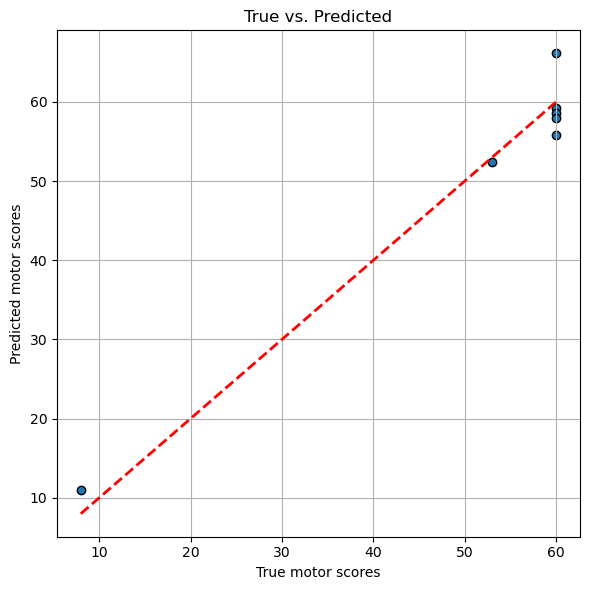

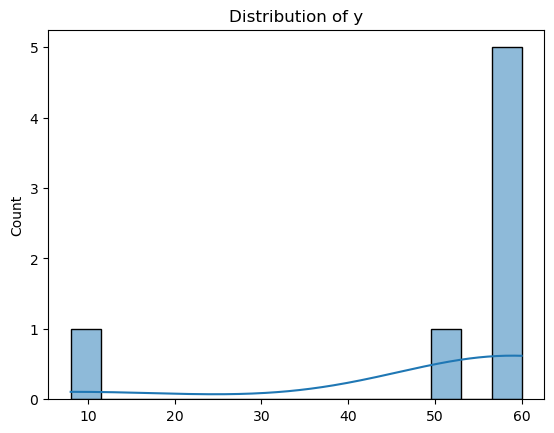

Plotting CDF for Fugl_Meyer_contra at time point T 4 , min/max: 8.0 60.0


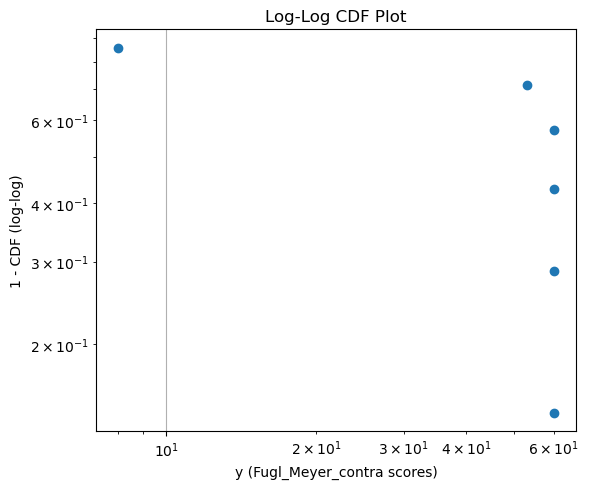

Plotting histogram with log-scaled y-axis for Fugl_Meyer_contra at time point T 4 to check for right-skewed distribution


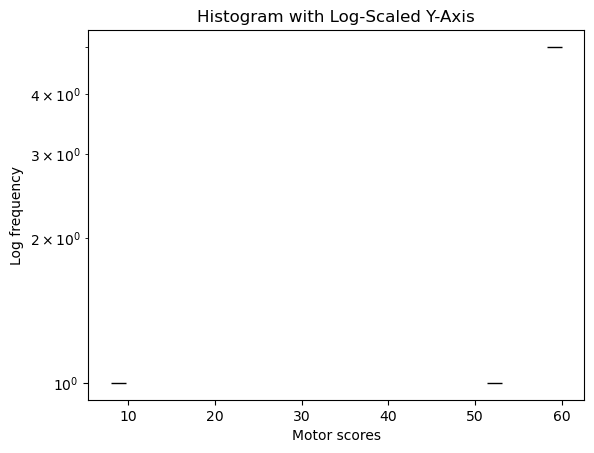

Plotting histogram of log1p(max - y) for Fugl_Meyer_contra at time point T 4 to check for left-skewed distribution


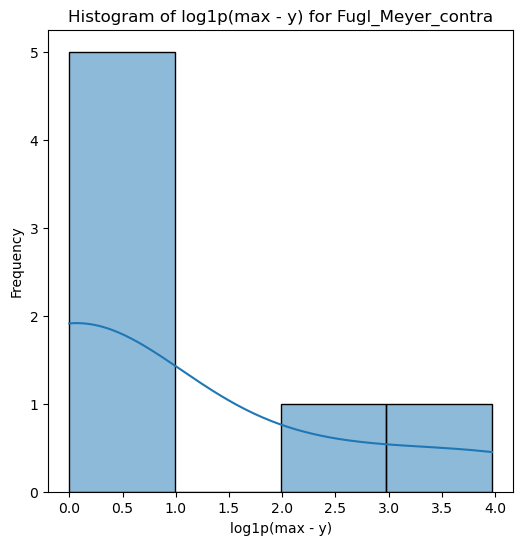

Running Ridge regression with RFE on reflected log-transformed y for Fugl_Meyer_contra at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                              Feature    Weight
3  Accumbens_ipsi|Rostral_Area_6_ipsi -0.422878
1      Pallidum_contra|Caudate_contra -0.408937
4    Accumbens_contra|Pallidum_contra -0.300218
2    Pallidum_contra|Accumbens_contra -0.300218
0       Pallidum_contra|Pallidum_ipsi -0.257696
Running Ridge regression with RFE on log-transformed y for Fugl_Meyer_contra at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                            Feature    Weight
2     Pallidum_contra|Pallidum_ipsi  0.161050
1     Pallidum_ipsi|Pallidum_contra  0.161050
4  Accumbens_contra|Pallidum_contra  0.152322
3  Pallidum_contra|Accumbens_contra  0.152322
0     Putamen_contra|Cerebellu_ipsi  0.142086
Running Random Forest regression with cross-validation for Fugl_Meyer_contra at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_L, regression_info, tp=4, motor_score='Fugl_Meyer_contra', striatum_labels=striatum_labels)

### nmf motor

Running Ridge regression with RFE for nmf_motor at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                            Feature    Weight
1     Pallidum_ipsi|Pallidum_contra -0.044295
2     Pallidum_contra|Pallidum_ipsi -0.044295
0     Caudate_contra|Area_3a_contra  0.041505
3  Pallidum_contra|Accumbens_contra -0.039736
4  Accumbens_contra|Pallidum_contra -0.039736
R² on full data: 0.960
Mean Squared Error: 0.001
Mean Absolute Error: 0.029
Plotting data distribution and predictions for nmf_motor at time point T 4


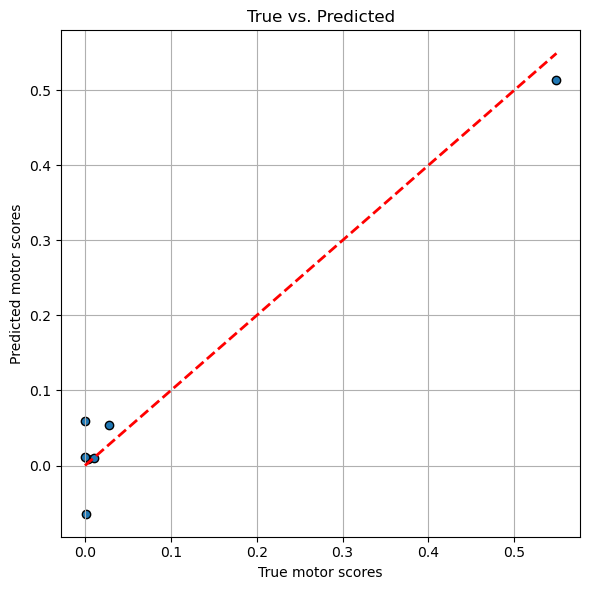

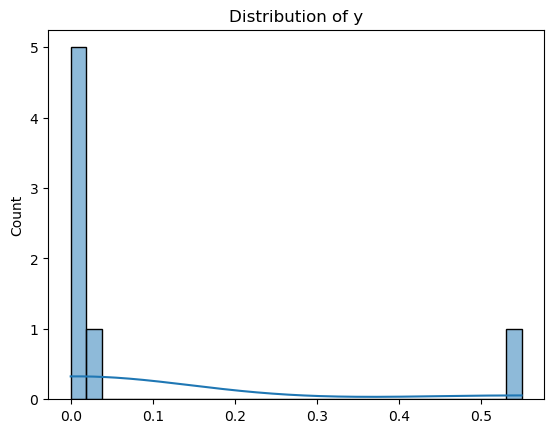

Plotting CDF for nmf_motor at time point T 4 , min/max: 0.0 0.549041087963167


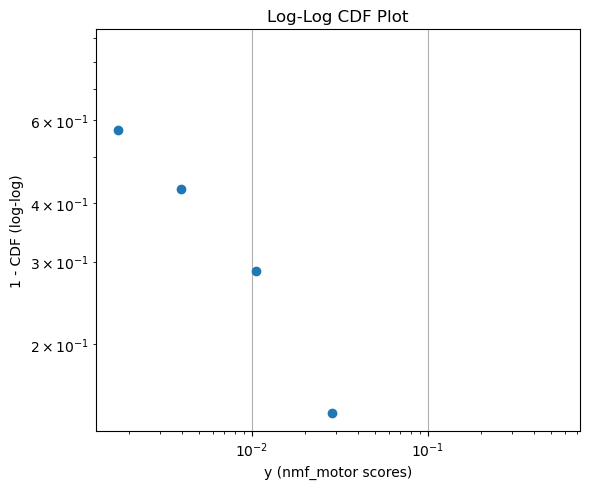

Plotting histogram with log-scaled y-axis for nmf_motor at time point T 4 to check for right-skewed distribution


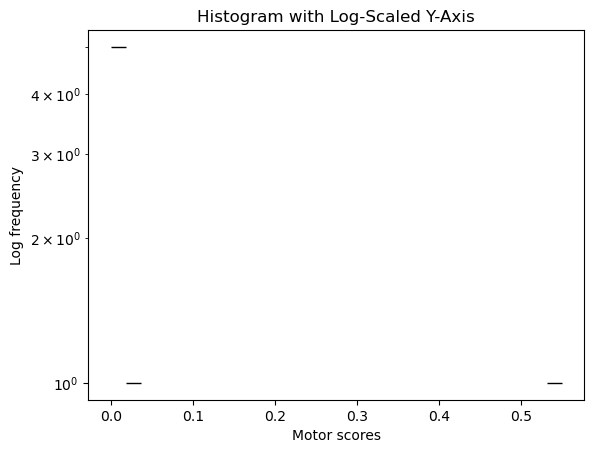

Plotting histogram of log1p(max - y) for nmf_motor at time point T 4 to check for left-skewed distribution


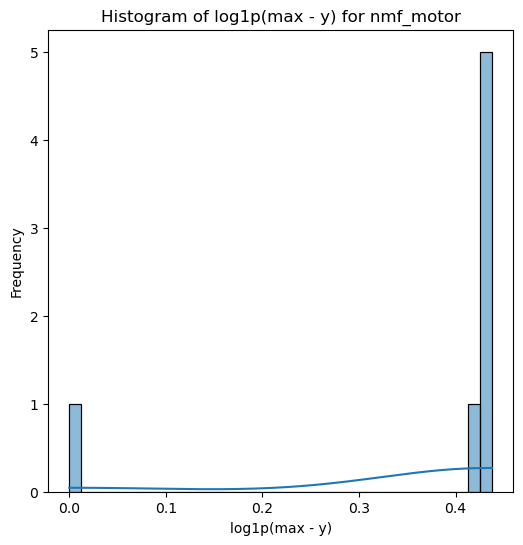

Running Ridge regression with RFE on reflected log-transformed y for nmf_motor at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                              Feature    Weight
2       Pallidum_contra|Pallidum_ipsi  0.044158
1       Pallidum_ipsi|Pallidum_contra  0.044158
0  Putamen_ipsi|Rostral_Area_6_contra -0.030576
3    Pallidum_contra|Accumbens_contra  0.030530
4    Accumbens_contra|Pallidum_contra  0.030530
Running Ridge regression with RFE on log-transformed y for nmf_motor at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Best number of features: 5
Best cross-validated R² score: nan
Top predictive features:
                               Feature    Weight
3        Pallidum_ipsi|Pallidum_contra -0.042067
1  Caudate_contra|Dorsal_area_6_contra  0.040184
2   Putamen_contra|Rostral_Area_6_ipsi -0.035139
0           Putamen_ipsi|Area_55b_ipsi -0.034641
4     Accumbens_contra|Pallidum_contra -0.034269
Running Random Forest regression with cross-validation for nmf_motor at time point T 4


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

Random Forest R² (CV): nan


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_L, regression_info, tp=4, motor_score='nmf_motor', striatum_labels=striatum_labels)

## R Split, T4

### Fuegl-Meyer Ipsi

Running Ridge regression with RFE for Fugl_Meyer_ipsi at time point T 4
Best number of features: 80
Best cross-validated R² score: -0.2121250948712336
Top predictive features:
                                  Feature    Weight
6     Caudate_ipsi|Area_6_anterior_contra  0.184248
20          Caudate_contra|Cerebellu_ipsi -0.176474
8              Caudate_ipsi|Area_1_contra  0.162494
9              Caudate_ipsi|Area_2_contra  0.151703
16           Putamen_ipsi|Area_55b_contra  0.150130
30  Caudate_contra|Area_6_anterior_contra  0.149968
45          Pallidum_ipsi|Area_55b_contra  0.148854
18            Putamen_ipsi|Area_3a_contra  0.147682
31           Caudate_contra|Area_1_contra  0.142829
28         Caudate_contra|Thalamus_contra -0.139399
R² on full data: 1.000
Mean Squared Error: 0.000
Mean Absolute Error: 0.011
Plotting data distribution and predictions for Fugl_Meyer_ipsi at time point T 4


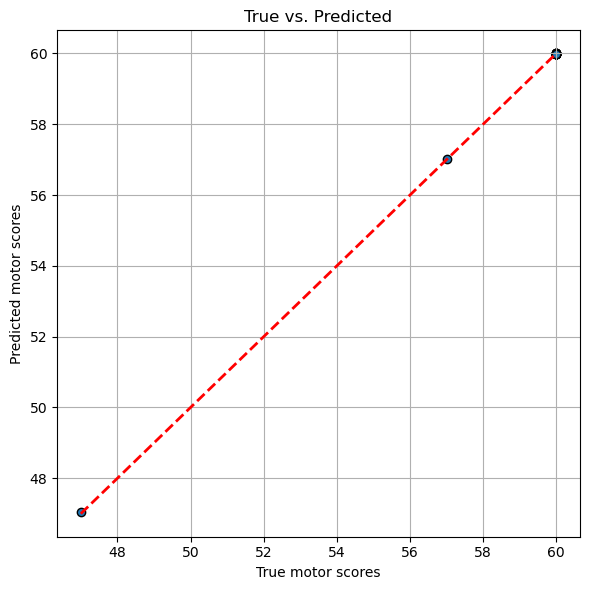

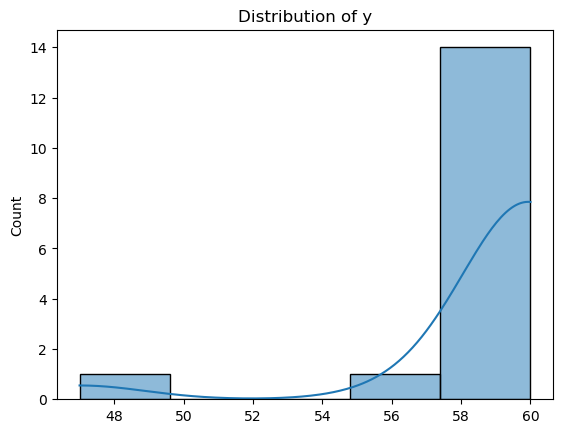

Plotting CDF for Fugl_Meyer_ipsi at time point T 4 , min/max: 47.0 60.0


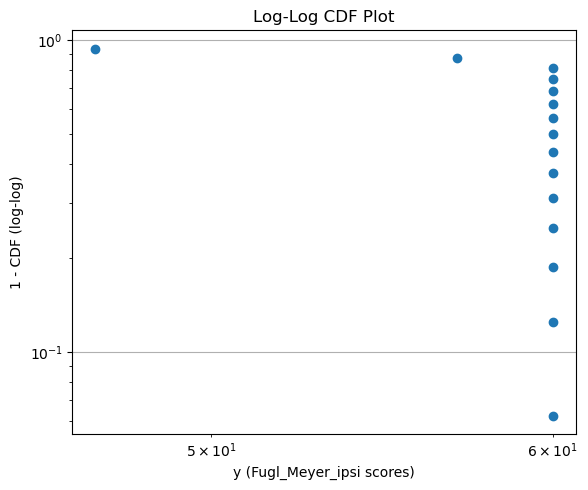

Plotting histogram with log-scaled y-axis for Fugl_Meyer_ipsi at time point T 4 to check for right-skewed distribution


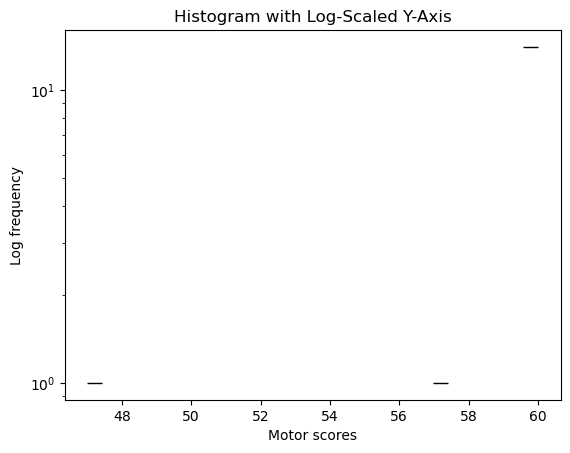

Plotting histogram of log1p(max - y) for Fugl_Meyer_ipsi at time point T 4 to check for left-skewed distribution


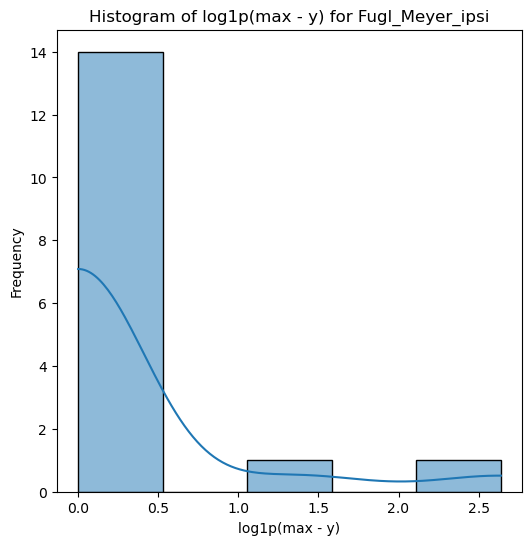

Running Ridge regression with RFE on reflected log-transformed y for Fugl_Meyer_ipsi at time point T 4
Best number of features: 30
Best cross-validated R² score: -0.13655615123382359
Top predictive features:
                                     Feature    Weight
7                Putamen_ipsi|Area_3a_contra -0.081471
9               Caudate_contra|Area_55b_ipsi  0.078029
8              Caudate_contra|Cerebellu_ipsi  0.075090
0        Caudate_ipsi|Area_6_anterior_contra -0.074756
21             Pallidum_ipsi|Area_55b_contra -0.069429
6               Putamen_ipsi|Area_55b_contra -0.067671
10        Caudate_contra|Ventral_Area_6_ipsi  0.058718
18           Putamen_contra|Cerebellu_contra -0.056066
12  Caudate_contra|Primary_Motor_Cortex_ipsi  0.055634
25    Pallidum_contra|Area_6_anterior_contra -0.053108
Running Ridge regression with RFE on log-transformed y for Fugl_Meyer_ipsi at time point T 4
Best number of features: 80
Best cross-validated R² score: -0.2329355077199491
Top predictive 

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_R, regression_info, tp=4, motor_score='Fugl_Meyer_ipsi')

### Fuegl-Meyer Contra

Running Ridge regression with RFE for Fugl_Meyer_contra at time point T 4
Best number of features: 80
Best cross-validated R² score: -0.692247797442359
Top predictive features:
                                Feature    Weight
50       Pallidum_contra|Cerebellu_ipsi  0.046164
11           Caudate_ipsi|Area_1_contra  0.045986
58       Pallidum_contra|Area_3a_contra -0.045050
22  Caudate_contra|Area_6_anterior_ipsi  0.041990
8         Caudate_ipsi|Cerebellu_contra -0.041157
24      Caudate_contra|Accumbens_contra -0.040923
74      Accumbens_contra|Caudate_contra -0.040923
61         Accumbens_ipsi|Area_55b_ipsi  0.039989
63           Accumbens_ipsi|Area_2_ipsi -0.039884
37       Putamen_contra|Area_55b_contra  0.039716
R² on full data: 1.000
Mean Squared Error: 0.000
Mean Absolute Error: 0.006
Plotting data distribution and predictions for Fugl_Meyer_contra at time point T 4


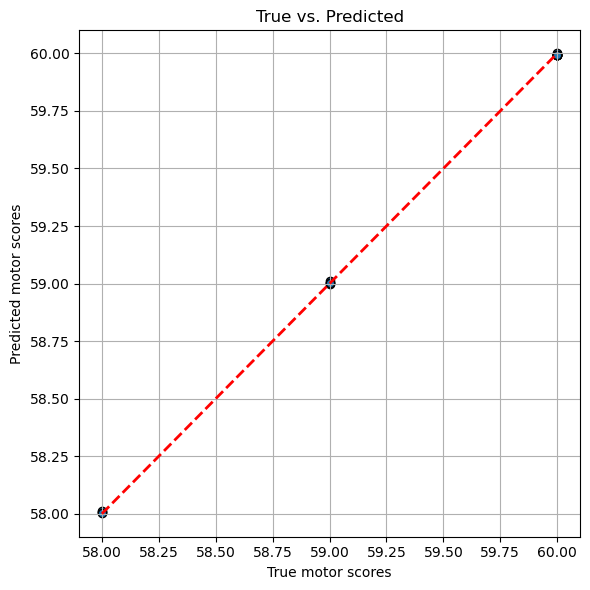

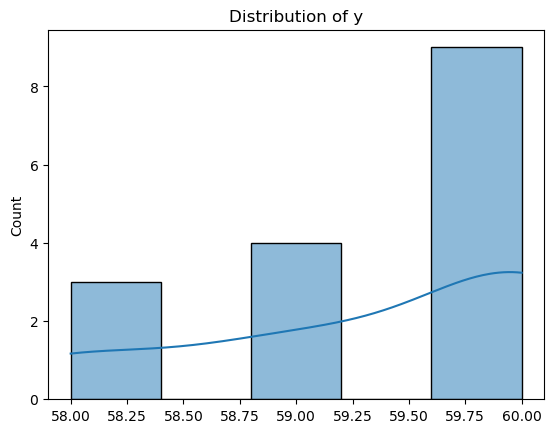

Plotting CDF for Fugl_Meyer_contra at time point T 4 , min/max: 58.0 60.0


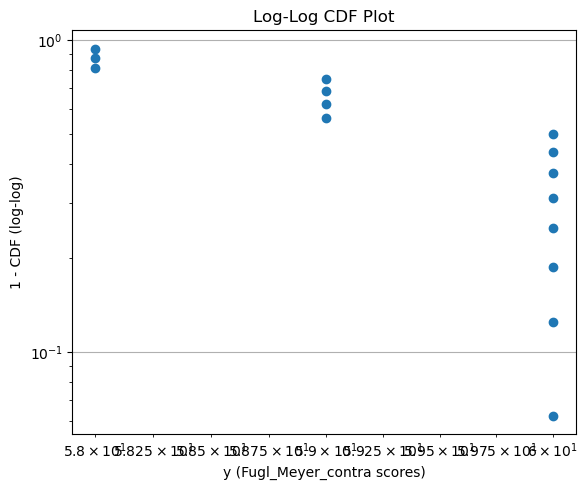

Plotting histogram with log-scaled y-axis for Fugl_Meyer_contra at time point T 4 to check for right-skewed distribution


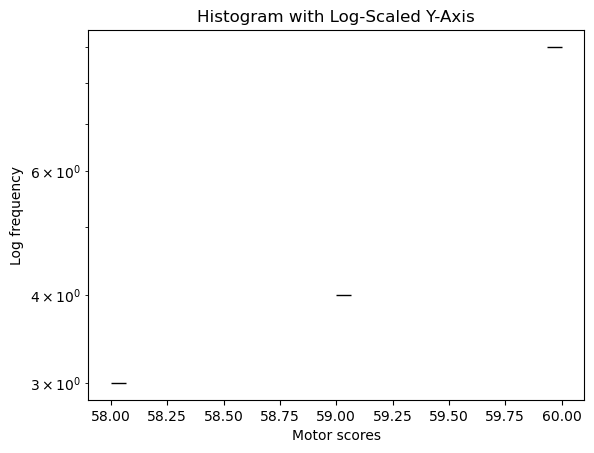

Plotting histogram of log1p(max - y) for Fugl_Meyer_contra at time point T 4 to check for left-skewed distribution


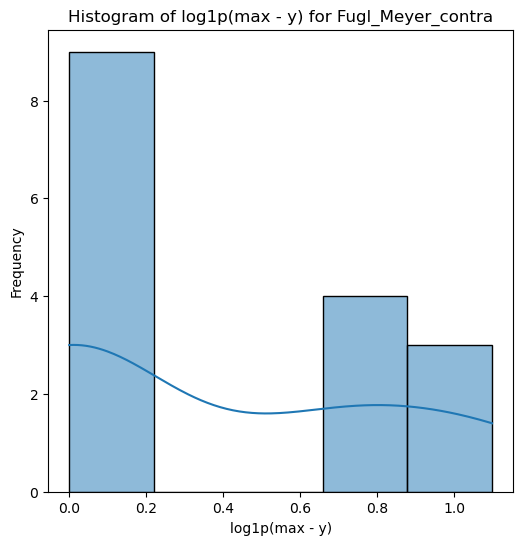

Running Ridge regression with RFE on reflected log-transformed y for Fugl_Meyer_contra at time point T 4
Best number of features: 40
Best cross-validated R² score: -0.6734975841001161
Top predictive features:
                                Feature    Weight
24       Pallidum_contra|Cerebellu_ipsi -0.043335
9   Caudate_contra|Area_6_anterior_ipsi -0.042093
30         Accumbens_ipsi|Area_55b_ipsi -0.041696
4            Caudate_ipsi|Area_1_contra -0.041628
31   Accumbens_ipsi|Rostral_Area_6_ipsi -0.036678
8     Caudate_contra|Dorsal_area_6_ipsi -0.035394
2         Caudate_ipsi|Cerebellu_contra  0.034663
32           Accumbens_ipsi|Area_2_ipsi  0.034193
1              Caudate_ipsi|Area_1_ipsi -0.033817
37      Accumbens_contra|Caudate_contra  0.033364
Running Ridge regression with RFE on log-transformed y for Fugl_Meyer_contra at time point T 4
Best number of features: 80
Best cross-validated R² score: -0.6843484262219416
Top predictive features:
                                Feature   

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_R, regression_info, tp=4, motor_score='Fugl_Meyer_contra')

### nmf_motor

Running Ridge regression with RFE for nmf_motor at time point T 4
Best number of features: 80
Best cross-validated R² score: -5.824206570621691
Top predictive features:
                                   Feature    Weight
12           Putamen_ipsi|Accumbens_contra -0.001458
68           Accumbens_contra|Putamen_ipsi -0.001458
64         Accumbens_ipsi|Cerebellu_contra -0.001438
49    Pallidum_ipsi|Area_6_anterior_contra  0.001259
66    Accumbens_ipsi|Ventral_Area_6_contra  0.001223
15      Putamen_ipsi|Ventral_Area_6_contra -0.001189
18             Putamen_ipsi|Area_3a_contra -0.001173
0                Caudate_ipsi|Putamen_ipsi -0.001155
3                Putamen_ipsi|Caudate_ipsi -0.001155
7   Putamen_ipsi|Primary_Motor_Cortex_ipsi -0.001152
R² on full data: 1.000
Mean Squared Error: 0.000
Mean Absolute Error: 0.000
Plotting data distribution and predictions for nmf_motor at time point T 4


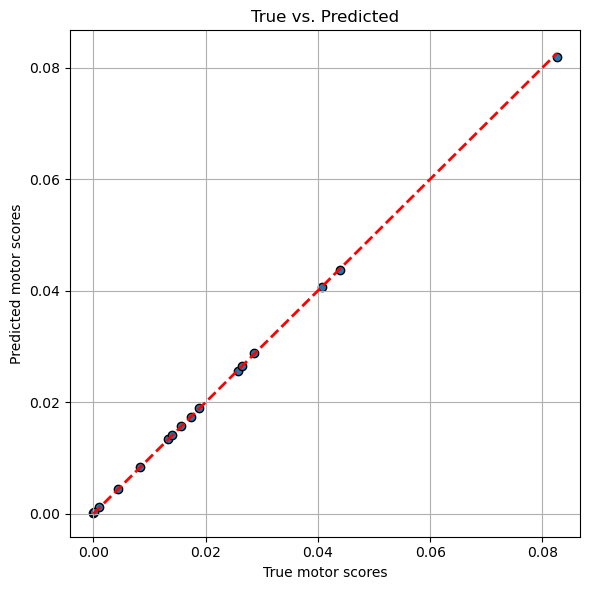

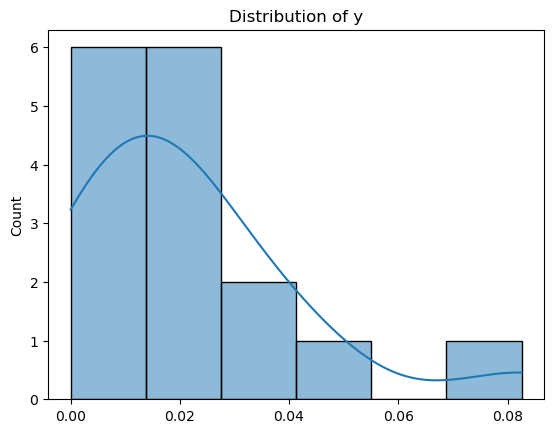

Plotting CDF for nmf_motor at time point T 4 , min/max: 0.0 0.0825793806468637


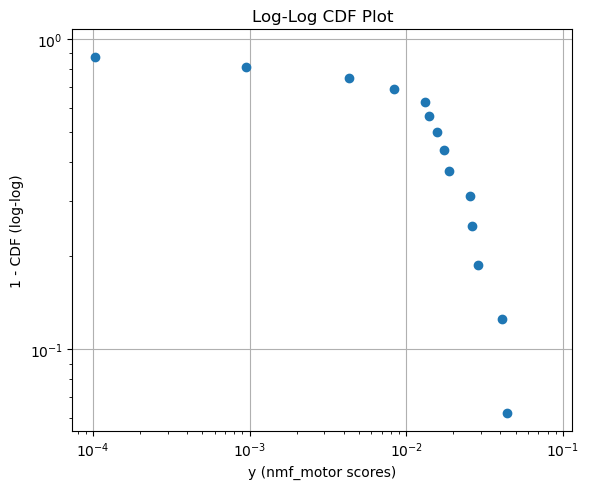

Plotting histogram with log-scaled y-axis for nmf_motor at time point T 4 to check for right-skewed distribution


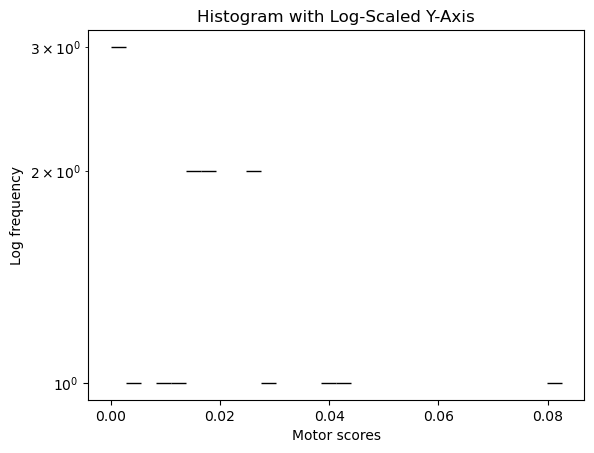

Plotting histogram of log1p(max - y) for nmf_motor at time point T 4 to check for left-skewed distribution


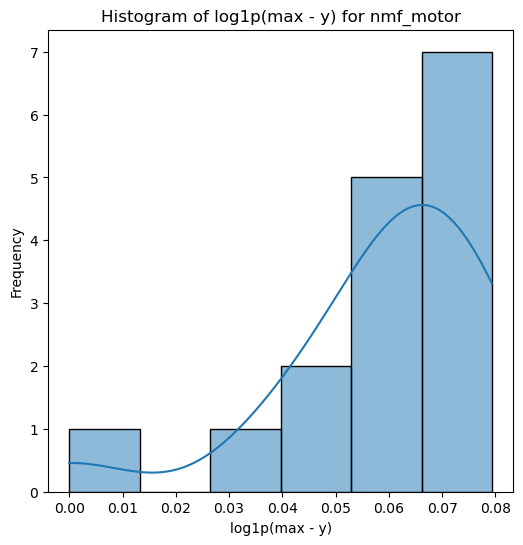

Running Ridge regression with RFE on reflected log-transformed y for nmf_motor at time point T 4
Best number of features: 80
Best cross-validated R² score: -5.856046133003944
Top predictive features:
                                   Feature    Weight
68           Accumbens_contra|Putamen_ipsi  0.001410
12           Putamen_ipsi|Accumbens_contra  0.001410
64         Accumbens_ipsi|Cerebellu_contra  0.001394
49    Pallidum_ipsi|Area_6_anterior_contra -0.001171
15      Putamen_ipsi|Ventral_Area_6_contra  0.001158
66    Accumbens_ipsi|Ventral_Area_6_contra -0.001149
18             Putamen_ipsi|Area_3a_contra  0.001137
7   Putamen_ipsi|Primary_Motor_Cortex_ipsi  0.001124
73       Accumbens_contra|Cerebellu_contra  0.001103
0                Caudate_ipsi|Putamen_ipsi  0.001101
Running Ridge regression with RFE on log-transformed y for nmf_motor at time point T 4
Best number of features: 80
Best cross-validated R² score: -5.536683492299991
Top predictive features:
                           

In [ ]:
selected_featur_names, grid = functions.run_whole_pipeline(df_aligned_R, regression_info, tp=4, motor_score='nmf_motor')


# Neural Net

In [241]:
def run_mlp_regression(X_df_clean, y_FMI):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(32,), max_iter=1000, random_state=42))
    ])

    scores = cross_val_score(pipe, X_df_clean, y_FMI, cv=cv, scoring='r2')
    print("MLP Pipeline R² (CV):", scores.mean())

    param_grid = {
        "rfe__n_features_to_select": [5, 10, 20],
        "ridge__alpha": [0.1, 1.0, 10.0]
    }

    pipe.fit(X_df_clean, y_FMI)  # Fit the full pipeline first

    result = permutation_importance(pipe, X_df_clean, y_FMI, scoring='r2', n_repeats=30, random_state=42)

    feature_importance = pd.DataFrame({
        "Feature": X_df_clean_t3.columns,
        "Importance": result.importances_mean
    }).sort_values(by="Importance", ascending=False)

    print(feature_importance.head(10))

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    mae_scores = cross_val_score(pipe, X_df_clean, y_FMI, cv=cv, scoring=mae_scorer)
    print("MLP MAE:", -mae_scores.mean())
    
    return feature_importance


### Whole group

#### T3

##### Fugl-Meyer Ipsi

In [242]:
feature_importance_t3 = run_mlp_regression(X_df_clean_t3, y_FMI_t3)

MLP Pipeline R² (CV): -633.6319114545569
                                 Feature  Importance
54    Putamen_ipsi|Ventral_Area_6_contra    1.496700
236    Accumbens_contra|Cerebellu_contra    0.981572
39      Putamen_ipsi|Rostral_Area_6_ipsi    0.902689
157        Pallidum_contra|Pallidum_ipsi    0.902173
160        Pallidum_contra|Thalamus_ipsi    0.889229
200          Accumbens_ipsi|Area_3a_ipsi    0.872802
156         Pallidum_contra|Putamen_ipsi    0.840235
38      Putamen_ipsi|Ventral_Area_6_ipsi    0.818065
163  Pallidum_contra|Ventral_Area_6_ipsi    0.811133
55    Putamen_ipsi|Rostral_Area_6_contra    0.774282
MLP MAE: 18.64514929357642


##### Fugl-Mayer Contra

In [243]:
feature_importance_t3 = run_mlp_regression(X_df_clean_t3, y_FMC_t3)

MLP Pipeline R² (CV): -242.56588649828038
                                     Feature  Importance
54        Putamen_ipsi|Ventral_Area_6_contra    0.010728
21              Caudate_ipsi|Area_55b_contra    0.008104
40         Putamen_ipsi|Area_6_anterior_ipsi    0.007810
39          Putamen_ipsi|Rostral_Area_6_ipsi    0.007206
236        Accumbens_contra|Cerebellu_contra    0.006680
109            Putamen_contra|Caudate_contra    0.006445
163      Pallidum_contra|Ventral_Area_6_ipsi    0.006326
242  Accumbens_contra|Area_6_anterior_contra    0.006268
161            Pallidum_contra|Area_55b_ipsi    0.006196
55        Putamen_ipsi|Rostral_Area_6_contra    0.006046
MLP MAE: 21.07883296206878


##### nmf motor

In [244]:
feature_importance_t3 = run_mlp_regression(X_df_clean_t3, y_nmf_t3)

MLP Pipeline R² (CV): -6344.339761722518
                                          Feature  Importance
243  Accumbens_contra|Primary_Motor_Cortex_contra    2.116151
226          Accumbens_contra|Rostral_Area_6_ipsi    1.124911
218                 Accumbens_contra|Putamen_ipsi    1.035161
215                  Accumbens_ipsi|Area_2_contra    0.975535
42       Putamen_ipsi|Primary_Sensory_Cortex_ipsi    0.901779
52                   Putamen_ipsi|Area_55b_contra    0.884750
177          Pallidum_contra|Dorsal_area_6_contra    0.822394
137                     Pallidum_ipsi|Area_2_ipsi    0.817524
45                      Putamen_ipsi|Area_3a_ipsi    0.808027
174              Pallidum_contra|Cerebellu_contra    0.774903
MLP MAE: 1.0412940762498193


### T4

##### Fugl-Meyer Ipsi

In [245]:
feature_importance_t4 = run_mlp_regression(X_df_clean_t4, y_FMI_t4)

MLP Pipeline R² (CV): -113.97239560707811
                                 Feature  Importance
54    Putamen_ipsi|Ventral_Area_6_contra    0.398003
163  Pallidum_contra|Ventral_Area_6_ipsi    0.261911
46           Putamen_ipsi|Caudate_contra    0.226611
157        Pallidum_contra|Pallidum_ipsi    0.224020
63           Caudate_contra|Putamen_ipsi    0.202604
160        Pallidum_contra|Thalamus_ipsi    0.201657
39      Putamen_ipsi|Rostral_Area_6_ipsi    0.190905
161        Pallidum_contra|Area_55b_ipsi    0.188789
38      Putamen_ipsi|Ventral_Area_6_ipsi    0.178839
141        Pallidum_ipsi|Pallidum_contra    0.172674
MLP MAE: 19.260957676641343


##### Fugl-Mayer Contra

In [246]:
feature_importance_t4 = run_mlp_regression(X_df_clean_t4, y_FMC_t4)

MLP Pipeline R² (CV): -916.0301517459524
                                     Feature  Importance
54        Putamen_ipsi|Ventral_Area_6_contra    0.027128
161            Pallidum_contra|Area_55b_ipsi    0.016607
242  Accumbens_contra|Area_6_anterior_contra    0.015887
19             Caudate_ipsi|Cerebellu_contra    0.015670
21              Caudate_ipsi|Area_55b_contra    0.015541
39          Putamen_ipsi|Rostral_Area_6_ipsi    0.013722
46               Putamen_ipsi|Caudate_contra    0.013541
236        Accumbens_contra|Cerebellu_contra    0.013068
238         Accumbens_contra|Area_55b_contra    0.012705
38          Putamen_ipsi|Ventral_Area_6_ipsi    0.012413
MLP MAE: 21.80323904745231


##### nmf motor

In [247]:
feature_importance_t4 = run_mlp_regression(X_df_clean_t4, y_nmf_t4)

MLP Pipeline R² (CV): -15693.3825083903
                                          Feature  Importance
243  Accumbens_contra|Primary_Motor_Cortex_contra    5.662709
215                  Accumbens_ipsi|Area_2_contra    4.560366
226          Accumbens_contra|Rostral_Area_6_ipsi    3.764218
213  Accumbens_ipsi|Primary_Sensory_Cortex_contra    3.566384
45                      Putamen_ipsi|Area_3a_ipsi    3.195215
174              Pallidum_contra|Cerebellu_contra    3.171939
42       Putamen_ipsi|Primary_Sensory_Cortex_ipsi    2.938952
211         Accumbens_ipsi|Area_6_anterior_contra    2.861865
218                 Accumbens_contra|Putamen_ipsi    2.738642
191                  Accumbens_ipsi|Area_55b_ipsi    2.456611
MLP MAE: 1.1410098528681747


## Split L/R

#### L, T3

##### Fugl-Meyer Ipsi

In [248]:
feature_importance_L_t3 = run_mlp_regression(X_df_clean_L_t3, y_FMI_L_t3)

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

MLP Pipeline R² (CV): nan
                                  Feature  Importance
236     Accumbens_contra|Cerebellu_contra    1.179702
98           Putamen_contra|Thalamus_ipsi    1.179161
222        Accumbens_contra|Thalamus_ipsi    0.951627
174      Pallidum_contra|Cerebellu_contra    0.898899
86   Caudate_contra|Rostral_Area_6_contra    0.843728
147   Pallidum_ipsi|Ventral_Area_6_contra    0.842743
157         Pallidum_contra|Pallidum_ipsi    0.836956
215          Accumbens_ipsi|Area_2_contra    0.822367
194    Accumbens_ipsi|Rostral_Area_6_ipsi    0.805346
173      Pallidum_contra|Accumbens_contra    0.769620
MLP MAE: 31.67261219476252


##### Fugl-Mayer Contra

In [251]:
feature_importance_t3 = run_mlp_regression(X_df_clean_L_t3, y_FMC_L_t3)

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

MLP Pipeline R² (CV): nan
                                  Feature  Importance
98           Putamen_contra|Thalamus_ipsi    0.003129
236     Accumbens_contra|Cerebellu_contra    0.003099
86   Caudate_contra|Rostral_Area_6_contra    0.002944
147   Pallidum_ipsi|Ventral_Area_6_contra    0.002859
215          Accumbens_ipsi|Area_2_contra    0.002803
19          Caudate_ipsi|Cerebellu_contra    0.002462
190          Accumbens_ipsi|Thalamus_ipsi    0.002444
222        Accumbens_contra|Thalamus_ipsi    0.002414
174      Pallidum_contra|Cerebellu_contra    0.002402
160         Pallidum_contra|Thalamus_ipsi    0.002366
MLP MAE: 26.676229128381514


##### nmf motor

In [252]:
feature_importance_t3 = run_mlp_regression(X_df_clean_L_t3, y_nmf_L_t3)

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

MLP Pipeline R² (CV): nan
                                      Feature  Importance
210      Accumbens_ipsi|Rostral_Area_6_contra    1.645977
227     Accumbens_contra|Area_6_anterior_ipsi    1.606593
1                  Caudate_ipsi|Pallidum_ipsi    1.553065
93                Putamen_contra|Caudate_ipsi    1.452101
177      Pallidum_contra|Dorsal_area_6_contra    1.380936
219            Accumbens_contra|Pallidum_ipsi    1.282111
11   Caudate_ipsi|Primary_Sensory_Cortex_ipsi    1.269068
215              Accumbens_ipsi|Area_2_contra    1.142407
137                 Pallidum_ipsi|Area_2_ipsi    1.080470
192         Accumbens_ipsi|Dorsal_area_6_ipsi    1.023825
MLP MAE: 1.6896482176880157


#### R, T3

##### Fugl-Meyer Ipsi

In [253]:
feature_importance_R_t3 = run_mlp_regression(X_df_clean_R_t3, y_FMI_R_t3)

MLP Pipeline R² (CV): -1486.9146835412134
                                  Feature  Importance
236     Accumbens_contra|Cerebellu_contra    0.703966
209  Accumbens_ipsi|Ventral_Area_6_contra    0.572104
219        Accumbens_contra|Pallidum_ipsi    0.564701
54     Putamen_ipsi|Ventral_Area_6_contra    0.549631
83         Caudate_contra|Area_55b_contra    0.517714
37        Putamen_ipsi|Dorsal_area_6_ipsi    0.514677
163   Pallidum_contra|Ventral_Area_6_ipsi    0.491633
131     Pallidum_ipsi|Ventral_Area_6_ipsi    0.479517
147   Pallidum_ipsi|Ventral_Area_6_contra    0.469983
38       Putamen_ipsi|Ventral_Area_6_ipsi    0.457433
MLP MAE: 24.670654475657738


##### Fugl-Mayer Contra

In [249]:
feature_importance_R_t3 = run_mlp_regression(X_df_clean_R_t3, y_FMC_R_t3)

MLP Pipeline R² (CV): -872.0119778329084
                                Feature  Importance
40    Putamen_ipsi|Area_6_anterior_ipsi    0.006975
54   Putamen_ipsi|Ventral_Area_6_contra    0.006059
236   Accumbens_contra|Cerebellu_contra    0.005908
83       Caudate_contra|Area_55b_contra    0.005854
37      Putamen_ipsi|Dorsal_area_6_ipsi    0.005726
219      Accumbens_contra|Pallidum_ipsi    0.005710
81      Caudate_contra|Cerebellu_contra    0.005483
142      Pallidum_ipsi|Accumbens_contra    0.005272
112     Putamen_contra|Cerebellu_contra    0.005167
108         Putamen_contra|Area_3a_ipsi    0.005066
MLP MAE: 27.14573250780043


##### nmf motor

In [250]:
feature_importance_R_t3 = run_mlp_regression(X_df_clean_R_t3, y_nmf_R_t3)

MLP Pipeline R² (CV): -42519.84192685699
                                          Feature  Importance
226          Accumbens_contra|Rostral_Area_6_ipsi    1.326581
215                  Accumbens_ipsi|Area_2_contra    1.248911
45                      Putamen_ipsi|Area_3a_ipsi    1.152982
52                   Putamen_ipsi|Area_55b_contra    1.083251
213  Accumbens_ipsi|Primary_Sensory_Cortex_contra    1.062123
211         Accumbens_ipsi|Area_6_anterior_contra    1.045965
42       Putamen_ipsi|Primary_Sensory_Cortex_ipsi    1.034674
222                Accumbens_contra|Thalamus_ipsi    0.980146
243  Accumbens_contra|Primary_Motor_Cortex_contra    0.871413
19                  Caudate_ipsi|Cerebellu_contra    0.842999
MLP MAE: 1.0956413513266612


#### L, T4

##### Fugl-Meyer Ipsi

In [254]:
feature_importance_L_t4 = run_mlp_regression(X_df_clean_L_t4, y_FMI_L_t4)

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

MLP Pipeline R² (CV): nan
                                Feature  Importance
174    Pallidum_contra|Cerebellu_contra    0.777424
98         Putamen_contra|Thalamus_ipsi    0.757659
17         Caudate_ipsi|Pallidum_contra    0.743606
157       Pallidum_contra|Pallidum_ipsi    0.710345
236   Accumbens_contra|Cerebellu_contra    0.694485
142      Pallidum_ipsi|Accumbens_contra    0.679235
194  Accumbens_ipsi|Rostral_Area_6_ipsi    0.678671
45            Putamen_ipsi|Area_3a_ipsi    0.676755
16          Caudate_ipsi|Putamen_contra    0.656536
155        Pallidum_contra|Caudate_ipsi    0.623518
MLP MAE: 33.04183361533


##### Fugl-Mayer Contra

In [255]:
feature_importance_t4 = run_mlp_regression(X_df_clean_L_t4, y_FMC_L_t4)

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

MLP Pipeline R² (CV): nan
                                        Feature  Importance
98                 Putamen_contra|Thalamus_ipsi    0.001959
174            Pallidum_contra|Cerebellu_contra    0.001950
16                  Caudate_ipsi|Putamen_contra    0.001927
86         Caudate_contra|Rostral_Area_6_contra    0.001775
147         Pallidum_ipsi|Ventral_Area_6_contra    0.001689
45                    Putamen_ipsi|Area_3a_ipsi    0.001673
10       Caudate_ipsi|Primary_Motor_Cortex_ipsi    0.001621
211       Accumbens_ipsi|Area_6_anterior_contra    0.001608
88   Caudate_contra|Primary_Motor_Cortex_contra    0.001608
160               Pallidum_contra|Thalamus_ipsi    0.001579
MLP MAE: 31.935319725789846


##### nmf motor

In [256]:
feature_importance_t4 = run_mlp_regression(X_df_clean_L_t4, y_nmf_L_t4)

/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.1

MLP Pipeline R² (CV): nan
                                      Feature  Importance
93                Putamen_contra|Caudate_ipsi    1.886776
177      Pallidum_contra|Dorsal_area_6_contra    1.777160
18              Caudate_ipsi|Accumbens_contra    1.675004
148       Pallidum_ipsi|Rostral_Area_6_contra    1.496081
1                  Caudate_ipsi|Pallidum_ipsi    1.493091
78              Caudate_contra|Putamen_contra    1.390887
210      Accumbens_ipsi|Rostral_Area_6_contra    1.373572
11   Caudate_ipsi|Primary_Sensory_Cortex_ipsi    1.219950
189             Accumbens_ipsi|Cerebellu_ipsi    1.185771
191              Accumbens_ipsi|Area_55b_ipsi    1.180549
MLP MAE: 1.9409057937472434


#### R, T4

##### Fugl-Meyer Ipsi

In [257]:
feature_importance_R_t4 = run_mlp_regression(X_df_clean_R_t4, y_FMI_R_t4)

MLP Pipeline R² (CV): -60.26003672200028
                                  Feature  Importance
209  Accumbens_ipsi|Ventral_Area_6_contra    0.174206
54     Putamen_ipsi|Ventral_Area_6_contra    0.145717
219        Accumbens_contra|Pallidum_ipsi    0.142229
236     Accumbens_contra|Cerebellu_contra    0.136732
12               Caudate_ipsi|Area_1_ipsi    0.135156
195   Accumbens_ipsi|Area_6_anterior_ipsi    0.132722
38       Putamen_ipsi|Ventral_Area_6_ipsi    0.131051
40      Putamen_ipsi|Area_6_anterior_ipsi    0.129301
142        Pallidum_ipsi|Accumbens_contra    0.126268
37        Putamen_ipsi|Dorsal_area_6_ipsi    0.121391
MLP MAE: 24.8524558184323


##### Fugl-Mayer Contra

In [258]:
feature_importance_t4 = run_mlp_regression(X_df_clean_R_t4, y_FMC_R_t4)

MLP Pipeline R² (CV): -1968.385760247599
                                  Feature  Importance
209  Accumbens_ipsi|Ventral_Area_6_contra    3.242509
12               Caudate_ipsi|Area_1_ipsi    2.884411
54     Putamen_ipsi|Ventral_Area_6_contra    2.802476
236     Accumbens_contra|Cerebellu_contra    2.676849
38       Putamen_ipsi|Ventral_Area_6_ipsi    2.316934
195   Accumbens_ipsi|Area_6_anterior_ipsi    2.219734
131     Pallidum_ipsi|Ventral_Area_6_ipsi    2.028012
13               Caudate_ipsi|Area_2_ipsi    1.996081
203        Accumbens_ipsi|Pallidum_contra    1.987104
163   Pallidum_contra|Ventral_Area_6_ipsi    1.982876
MLP MAE: 25.486158968156097


##### nmf motor

In [259]:
feature_importance_t4 = run_mlp_regression(X_df_clean_R_t4, y_nmf_R_t4)

MLP Pipeline R² (CV): -27487.528371644552
                                          Feature  Importance
226          Accumbens_contra|Rostral_Area_6_ipsi  149.746773
215                  Accumbens_ipsi|Area_2_contra  132.490644
243  Accumbens_contra|Primary_Motor_Cortex_contra  113.429720
31                      Putamen_ipsi|Caudate_ipsi  101.818017
45                      Putamen_ipsi|Area_3a_ipsi   96.347844
42       Putamen_ipsi|Primary_Sensory_Cortex_ipsi   96.337289
52                   Putamen_ipsi|Area_55b_contra   93.946365
222                Accumbens_contra|Thalamus_ipsi   90.541424
227         Accumbens_contra|Area_6_anterior_ipsi   84.549162
19                  Caudate_ipsi|Cerebellu_contra   84.541956
MLP MAE: 1.2239486214732027


## Small attempt at feature selection with neural net

In [ ]:
# Shitty as well :D

from sklearn.feature_selection import SelectKBest, f_regression

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("select", SelectKBest(f_regression, k=20)),
    ("mlp", MLPRegressor(hidden_layer_sizes=(32,), max_iter=1000))
])

scores = cross_val_score(pipe, X_df_clean_t3, y_FMI_t3, cv=5, scoring='r2')
print("MLP (k=20) R²:", scores.mean())


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the opti

MLP (k=20) R²: -137.66270641631667


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [157]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor

y_FMC = valid_data['Fugl_Meyer_contra'].values

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(32,), max_iter=1000, random_state=42))
])

scores = cross_val_score(pipe, X_df_clean, y_FMC, cv=cv, scoring='r2')
print("MLP Pipeline R² (CV):", scores.mean())


param_grid = {
    "rfe__n_features_to_select": [5, 10, 20],
    "ridge__alpha": [0.1, 1.0, 10.0]
}

#grid = GridSearchCV(pipe, param_grid, cv=5)


pipe.fit(X_df_clean, y_FMI)  # Fit the full pipeline first

result = permutation_importance(pipe, X_df_clean, y_FMC, scoring='r2', n_repeats=30, random_state=42)

feature_importance = pd.DataFrame({
    "Feature": X_df_clean.columns,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

print(feature_importance.head(10))


MLP Pipeline R² (CV): -916.0301517459524
                                Feature  Importance
54   Putamen_ipsi|Ventral_Area_6_contra    0.045340
238    Accumbens_contra|Area_55b_contra    0.033836
29           Caudate_ipsi|Area_2_contra    0.031598
190        Accumbens_ipsi|Thalamus_ipsi    0.028331
46          Putamen_ipsi|Caudate_contra    0.027562
161       Pallidum_contra|Area_55b_ipsi    0.024183
122        Putamen_contra|Area_2_contra    0.023814
63          Caudate_contra|Putamen_ipsi    0.023523
66        Caudate_contra|Cerebellu_ipsi    0.022066
28           Caudate_ipsi|Area_1_contra    0.020466


# DummyRegressor test

In [ ]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
print("Dummy R²:", cross_val_score(dummy, X_df_clean_t3, y_FMI_t3, cv=5, scoring="r2").mean())


Dummy R²: -0.050597973345406236


# Classification now, with log reg and RFE, as in paper

In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
import numpy as np
import pandas as pd
from collections import defaultdict

'''def nagelkerke_r2(y_true, y_pred_proba, y_null_proba):
    """
    Compute Nagelkerke's pseudo-R² for classification.
    """
    N = len(y_true)
    logL_model = -log_loss(y_true, y_pred_proba, normalize=False)
    logL_null = -log_loss(y_true, y_null_proba, normalize=False)
    r2 = (1 - np.exp(-2 * (logL_model - logL_null) / N)) / (1 - np.exp(-2 * logL_null / N))
    return r2'''
    

'''def nagelkerke_r2(y_true, y_pred_proba, y_null_proba):
    """
    Compute Nagelkerke's pseudo-R² for classification.
    """
    classes = np.unique(y_true)  # Ensure both 0 and 1 are supported

    N = len(y_true)
    logL_model = -log_loss(y_true, y_pred_proba, labels=classes, normalize=False)
    logL_null = -log_loss(y_true, y_null_proba, labels=classes, normalize=False)

    r2 = (1 - np.exp(-2 * (logL_model - logL_null) / N)) / (1 - np.exp(-2 * logL_null / N))
    return r2'''

from sklearn.metrics import log_loss

def nagelkerke_r2(y_true, y_pred_proba, y_null_proba):
    """
    Compute Nagelkerke's pseudo-R² for binary classification,
    robust to test sets that contain only one class.
    """
    N = len(y_true)
    try:
        logL_model = -log_loss(y_true, y_pred_proba, labels=[0, 1], normalize=False)
        logL_null = -log_loss(y_true, y_null_proba, labels=[0, 1], normalize=False)
    except ValueError:
        return None  # In case log_loss fails despite labels arg

    r2 = (1 - np.exp(-2 * (logL_model - logL_null) / N)) / (1 - np.exp(-2 * logL_null / N))
    return r2


def run_classification_with_rfe_tracking(X_df, y, n_splits=100, test_size=0.1, min_accuracy_threshold=0.9):
    """
    Classification with RFE and repeated subsampling based on Adhikari et al., 2021.
    Also computes average Nagelkerke R² over successful splits.

    Parameters
    ----------
    X_df : pd.DataFrame
        Z-scored input features.
    y : np.array
        Target binary class labels (0 or 1).
    n_splits : int
        Number of train/test splits to repeat.
    test_size : float
        Proportion of data to hold out for testing.
    min_accuracy_threshold : float
        Minimum accuracy required to retain feature set and compute R².

    Returns
    -------
    feature_ranking_counts : pd.Series
        How often each feature was selected across good splits.
    r2_scores : list
        List of Nagelkerke R² values from each successful split.
    """
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)
    feature_counts = defaultdict(int)
    r2_scores = []

    for train_idx, test_idx in sss.split(X_df, y):
        X_train, X_test = X_df.iloc[train_idx], X_df.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Fit MLR with RFE
        base_model = LogisticRegression(max_iter=1000, solver='lbfgs')  # Let multi_class be automatic
        rfe = RFE(estimator=base_model, n_features_to_select=1, step=1)
        rfe.fit(X_train, y_train)

        # Get feature ranking order (best to worst)
        ranking_order = np.argsort(rfe.ranking_)

        # Track accuracy and R² as we reduce features
        best_features = []
        best_accuracy = 0
        best_r2 = None

        for i in range(1, len(ranking_order) + 1):
            selected = X_train.columns[ranking_order[:i]]
            model = LogisticRegression(max_iter=1000, solver='lbfgs')
            model.fit(X_train[selected], y_train)
            y_pred = model.predict(X_test[selected])
            acc = accuracy_score(y_test, y_pred)

            if acc >= min_accuracy_threshold and acc >= best_accuracy:
                best_accuracy = acc
                best_features = selected.tolist()  # Convert to plain list

                # Compute Nagelkerke R²
                y_pred_proba = model.predict_proba(X_test[selected])
                y_null_proba = np.tile(np.bincount(y_train) / len(y_train), (len(y_test), 1))
                best_r2 = nagelkerke_r2(y_test, y_pred_proba, y_null_proba)

        if len(best_features) > 0:
            for feat in best_features:
                feature_counts[feat] += 1
            if best_r2 is not None:
                r2_scores.append(best_r2)


    feature_ranking_counts = pd.Series(feature_counts).sort_values(ascending=False)
    return feature_ranking_counts, r2_scores

### whole group

#### T3

##### FMI

In [ ]:

# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_df_clean_t3)
X_z = pd.DataFrame(X_scaled, columns=X_df_clean_t3.columns)
y_class = (y_FMI_t3 < y_FMI_t3.mean()).astype(int)

# Define binary or multiclass target => 1 mean
feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z, y_class)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Putamen_contra|Area_6_anterior_ipsi              100
Accumbens_ipsi|Cerebellu_contra                  100
Accumbens_contra|Accumbens_ipsi                  100
Caudate_ipsi|Area_3a_ipsi                        100
Accumbens_contra|Area_55b_ipsi                   100
Accumbens_ipsi|Thalamus_ipsi                     100
Pallidum_contra|Primary_Sensory_Cortex_contra    100
Accumbens_contra|Primary_Motor_Cortex_contra     100
Putamen_contra|Thalamus_ipsi                     100
Caudate_contra|Area_55b_ipsi                     100
dtype: int64
Mean Nagelkerke R² over good splits: -0.322


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1])

##### FMC

In [ ]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_df_clean_t3)
X_z = pd.DataFrame(X_scaled, columns=X_df_clean_t3.columns)
y_class = (y_FMC_t3 < y_FMC_t3.mean()).astype(int)  # or use 0/1/2 labels

# Define binary or multiclass target => 1 mean

feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z, y_class)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Accumbens_contra|Pallidum_contra            96
Caudate_contra|Ventral_Area_6_ipsi          95
Caudate_ipsi|Area_55b_contra                95
Putamen_contra|Primary_Motor_Cortex_ipsi    95
Putamen_contra|Area_6_anterior_contra       94
Caudate_ipsi|Cerebellu_contra               94
Pallidum_ipsi|Primary_Motor_Cortex_ipsi     94
Pallidum_contra|Accumbens_contra            94
Putamen_contra|Area_3a_ipsi                 94
Pallidum_contra|Caudate_contra              87
dtype: int64
Mean Nagelkerke R² over good splits: -0.278


##### nmf

In [ ]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_df_clean_t3)
X_z = pd.DataFrame(X_scaled, columns=X_df_clean_t3.columns)
y_class = (y_nmf_t3 < y_nmf_t3.mean()).astype(int)  # or use 0/1/2 labels

# Define binary or multiclass target => 1 mean

feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z, y_class)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Putamen_ipsi|Primary_Motor_Cortex_ipsi          1
Accumbens_ipsi|Rostral_Area_6_ipsi              1
Accumbens_contra|Cerebellu_ipsi                 1
Accumbens_ipsi|Primary_Sensory_Cortex_contra    1
Pallidum_contra|Caudate_ipsi                    1
dtype: int64
Mean Nagelkerke R² over good splits: -0.173


#### T4

##### FMI

In [260]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_df_clean_t4)
X_z = pd.DataFrame(X_scaled, columns=X_df_clean_t4.columns)
y_class = (y_FMI_t4 < y_FMI_t4.mean()).astype(int)

# Define binary or multiclass target => 1 mean
feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z, y_class)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Putamen_contra|Area_6_anterior_ipsi              100
Accumbens_ipsi|Cerebellu_contra                  100
Accumbens_contra|Accumbens_ipsi                  100
Caudate_ipsi|Area_3a_ipsi                        100
Accumbens_contra|Area_55b_ipsi                   100
Accumbens_ipsi|Thalamus_ipsi                     100
Pallidum_contra|Primary_Sensory_Cortex_contra    100
Accumbens_contra|Primary_Motor_Cortex_contra     100
Putamen_contra|Thalamus_ipsi                     100
Caudate_contra|Area_55b_ipsi                     100
dtype: int64
Mean Nagelkerke R² over good splits: -0.322


##### FMC

In [ ]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_df_clean_t4)
X_z = pd.DataFrame(X_scaled, columns=X_df_clean_t4.columns)
y_class = (y_FMC_t4 < y_FMC_t4.mean()).astype(int)  # or use 0/1/2 labels

# Define binary or multiclass target => 1 mean

feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z, y_class)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Accumbens_contra|Pallidum_contra            96
Caudate_contra|Ventral_Area_6_ipsi          95
Caudate_ipsi|Area_55b_contra                95
Putamen_contra|Primary_Motor_Cortex_ipsi    95
Putamen_contra|Area_6_anterior_contra       94
Caudate_ipsi|Cerebellu_contra               94
Pallidum_ipsi|Primary_Motor_Cortex_ipsi     94
Pallidum_contra|Accumbens_contra            94
Putamen_contra|Area_3a_ipsi                 94
Pallidum_contra|Caudate_contra              87
dtype: int64
Mean Nagelkerke R² over good splits: -0.278


##### nmf

In [261]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_df_clean_t4)
X_z = pd.DataFrame(X_scaled, columns=X_df_clean_t4.columns)
y_class = (y_nmf_t4 < y_nmf_t4.mean()).astype(int)  # or use 0/1/2 labels

# Define binary or multiclass target => 1 mean

feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z, y_class)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Putamen_ipsi|Primary_Motor_Cortex_ipsi          1
Accumbens_ipsi|Rostral_Area_6_ipsi              1
Accumbens_contra|Cerebellu_ipsi                 1
Accumbens_ipsi|Primary_Sensory_Cortex_contra    1
Pallidum_contra|Caudate_ipsi                    1
dtype: int64
Mean Nagelkerke R² over good splits: -0.173


### Split L/R

#### T3, L

##### FMI

In [ ]:

# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled_L = StandardScaler().fit_transform(X_df_clean_L_t3)
X_z_L = pd.DataFrame(X_scaled_L, columns=X_df_clean_L_t3.columns)
y_class_L = (y_FMI_L_t3 < y_FMI_L_t3.mean()).astype(int)

# Define binary or multiclass target => 1 mean
feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z_L, y_class_L)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

##### FMC

In [ ]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled_L = StandardScaler().fit_transform(X_df_clean_L_t3)
X_z_L = pd.DataFrame(X_scaled_L, columns=X_df_clean_L_t3.columns)
y_class_L = (y_FMC_L_t3 < y_FMC_L_t3.mean()).astype(int)  # or use 0/1/2 labels

# Define binary or multiclass target => 1 mean

feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z_L, y_class_L)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

ValueError: The test_size = 1 should be greater or equal to the number of classes = 2

##### nmf

In [ ]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled_L = StandardScaler().fit_transform(X_df_clean_L_t3)
X_z_L = pd.DataFrame(X_scaled_L, columns=X_df_clean_L_t3.columns)
y_class_L = (y_nmf_L_t3 < y_nmf_L_t3.mean()).astype(int)  # or use 0/1/2 labels

# Define binary or multiclass target => 1 mean

feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z_L, y_class_L)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

#### T3, R

##### FMI

In [ ]:

# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled_R = StandardScaler().fit_transform(X_df_clean_R_t3)
X_z_R = pd.DataFrame(X_scaled_R, columns=X_df_clean_R_t3.columns)
y_class_R = (y_FMI_R_t3 < y_FMI_R_t3.mean()).astype(int)

# Define binary or multiclass target => 1 mean
feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z_R, y_class_R)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Accumbens_contra|Primary_Motor_Cortex_ipsi    19
Caudate_contra|Area_2_contra                  19
Caudate_contra|Dorsal_area_6_ipsi             19
Pallidum_ipsi|Thalamus_contra                 19
Putamen_contra|Cerebellu_contra               19
Accumbens_contra|Ventral_Area_6_ipsi          19
Putamen_contra|Dorsal_area_6_ipsi             19
Accumbens_contra|Cerebellu_contra             19
Accumbens_contra|Area_6_anterior_ipsi         18
Putamen_contra|Ventral_Area_6_contra          17
dtype: int64
Mean Nagelkerke R² over good splits: -0.172


##### FMC

In [262]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled_R = StandardScaler().fit_transform(X_df_clean_R_t3)
X_z_R = pd.DataFrame(X_scaled_R, columns=X_df_clean_R_t3.columns)
y_class_R = (y_FMC_R_t3 < y_FMC_R_t3.mean()).astype(int)  # or use 0/1/2 labels

# Define binary or multiclass target => 1 mean

feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z_R, y_class_R)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Caudate_contra|Primary_Motor_Cortex_ipsi    100
Accumbens_ipsi|Rostral_Area_6_contra        100
Putamen_ipsi|Area_1_ipsi                    100
Pallidum_ipsi|Caudate_contra                100
Accumbens_contra|Area_6_anterior_contra     100
Putamen_contra|Accumbens_ipsi               100
Pallidum_contra|Area_3a_ipsi                100
Caudate_contra|Pallidum_ipsi                100
Accumbens_ipsi|Putamen_contra               100
Caudate_ipsi|Dorsal_area_6_ipsi             100
dtype: int64
Mean Nagelkerke R² over good splits: -0.656


##### nmf

In [ ]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled_R = StandardScaler().fit_transform(X_df_clean_R_t3)
X_z = pd.DataFrame(X_scaled, columns=X_df_clean_R_t3.columns)
y_class = (y_nmf_R_t3 < y_nmf_R_t3.mean()).astype(int)  # or use 0/1/2 labels

# Define binary or multiclass target => 1 mean

feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z, y_class)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Putamen_ipsi|Primary_Motor_Cortex_ipsi          1
Accumbens_ipsi|Rostral_Area_6_ipsi              1
Accumbens_contra|Cerebellu_ipsi                 1
Accumbens_ipsi|Primary_Sensory_Cortex_contra    1
Pallidum_contra|Caudate_ipsi                    1
dtype: int64
Mean Nagelkerke R² over good splits: -0.173


#### T4, R

##### FMI

In [263]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled_R = StandardScaler().fit_transform(X_df_clean_R_t4)
X_z_R = pd.DataFrame(X_scaled_R, columns=X_df_clean_R_t4.columns)
y_class_R = (y_FMI_R_t4 < y_FMI_R_t4.mean()).astype(int)

# Define binary or multiclass target => 1 mean
feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z_R, y_class_R)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Putamen_ipsi|Area_55b_contra           100
Pallidum_ipsi|Area_3a_ipsi             100
Accumbens_ipsi|Rostral_Area_6_ipsi     100
Putamen_ipsi|Rostral_Area_6_ipsi       100
Caudate_contra|Caudate_ipsi            100
Pallidum_ipsi|Area_2_contra            100
Caudate_contra|Thalamus_ipsi           100
Pallidum_contra|Ventral_Area_6_ipsi    100
Accumbens_ipsi|Cerebellu_ipsi          100
Caudate_ipsi|Accumbens_contra          100
dtype: int64
Mean Nagelkerke R² over good splits: -0.518


##### FMC

In [264]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled_R = StandardScaler().fit_transform(X_df_clean_R_t4)
X_z_R = pd.DataFrame(X_scaled_R, columns=X_df_clean_R_t4.columns)
y_class_R = (y_FMC_R_t4 < y_FMC_R_t4.mean()).astype(int)  # or use 0/1/2 labels

# Define binary or multiclass target => 1 mean

feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z_R, y_class_R)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

Top features:
Putamen_contra|Area_55b_contra          38
Caudate_contra|Area_6_anterior_ipsi     37
Caudate_ipsi|Area_2_contra              37
Caudate_ipsi|Area_2_ipsi                35
Accumbens_contra|Area_55b_contra        35
Caudate_contra|Area_55b_contra          34
Accumbens_ipsi|Rostral_Area_6_contra    34
Accumbens_ipsi|Area_2_ipsi              34
Caudate_ipsi|Dorsal_area_6_ipsi         34
Putamen_contra|Caudate_ipsi             34
dtype: int64
Mean Nagelkerke R² over good splits: -0.150


##### nmf

In [266]:
# Preprocessing: z-score the features
from sklearn.preprocessing import StandardScaler

X_scaled_R = StandardScaler().fit_transform(X_df_clean_R_t4)
X_z = pd.DataFrame(X_scaled_R, columns=X_df_clean_R_t4.columns)
y_class = (y_nmf_R_t4 < y_nmf_R_t4.mean()).astype(int)  # or use 0/1/2 labels

# Define binary or multiclass target => 1 mean

feature_counts, r2_scores = run_classification_with_rfe_tracking(X_z, y_class)

print("Top features:")
print(feature_counts.head(10))

print(f"Mean Nagelkerke R² over good splits: {np.mean(r2_scores):.3f}")

y_nmf_R_t4

Top features:
Caudate_contra|Thalamus_ipsi            63
Accumbens_ipsi|Cerebellu_contra         51
Pallidum_ipsi|Area_6_anterior_contra    50
Caudate_contra|Cerebellu_ipsi           45
Accumbens_contra|Accumbens_ipsi         42
Accumbens_ipsi|Accumbens_contra         41
Accumbens_contra|Area_3a_contra         40
Pallidum_contra|Pallidum_ipsi           38
Putamen_contra|Cerebellu_ipsi           37
Pallidum_contra|Cerebellu_ipsi          35
dtype: int64
Mean Nagelkerke R² over good splits: -0.134


array([0.0439365 , 0.01888602, 0.04076053, 0.0156574 , 0.00434151,
       0.02865537, 0.0009486 , 0.01740773, 0.02570693, 0.        ,
       0.02652558, 0.00833476, 0.01326511, 0.01392131, 0.00010338,
       0.08257938])

# Trying to shift the data to apply my best models again (classifier)

In [269]:
# print the distribution of my y
print("Distribution of y_FMI_t4:")
print(y_FMI_t4)
print("Distribution of y_FMC_t4:")
print(y_FMC_t4)
print("Distribution of y_nmf_t4:")
print(y_nmf_t4)
# Preprocessing: z-score the features

Distribution of y_FMI_t4:
[60. 60. 60. 60. 57. 60. 60. 60. 60. 60. 60. 60. 60. 60. 47. 60. 60. 60.
 60. 60. 60. 60. 57.]
Distribution of y_FMC_t4:
[60. 60. 58. 60. 53. 59. 58. 60. 60. 60. 59. 60. 60. 59. 58. 60. 60. 59.
 60. 60. 60.  8. 60.]
Distribution of y_nmf_t4:
[4.39364992e-02 1.88860245e-02 4.07605324e-02 1.56574036e-02
 2.84972806e-02 4.34150540e-03 2.86553688e-02 1.74549993e-03
 9.48602076e-04 1.74077273e-02 2.57069312e-02 0.00000000e+00
 3.96561906e-03 2.65255777e-02 8.33476225e-03 1.06478901e-02
 1.32651102e-02 1.39213081e-02 0.00000000e+00 0.00000000e+00
 1.03378449e-04 5.49041088e-01 8.25793806e-02]
